# Example usage notebook of the DD-GAN repo

In [1]:
import time
import numpy as np
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy

After installation of the ddgan package run the following line to import it

In [2]:
import ddgan
from ddgan import *

### Loading Data

In [8]:
nPOD = 10
nlatent = 100

evaluated_subdomains = 2
subdomains = 4
dims = 3
added_dims = [1,1,3]
cumulative_dims = [0,1,2]

steps = added_dims[-1]
start_from = 50 # 100 works
datapoints = 1800 + steps + 50
step_size = 4

t_begin = 0
t_end = 1800

debug = False
train = True
find_old_model = False
noise = False #False
epochs = 100 
n_gradient_ascent = 10


csv_data = np.load('../data/processed/DD/pod_coeffs_field_Velocity.npy', )

assert nPOD <= csv_data.shape[1], "Make sure the data includes enough POD coeffs"
assert datapoints + start_from <= csv_data.shape[2], "Not enough data"
assert evaluated_subdomains + 2 <= csv_data.shape[0], "Not enough domains"

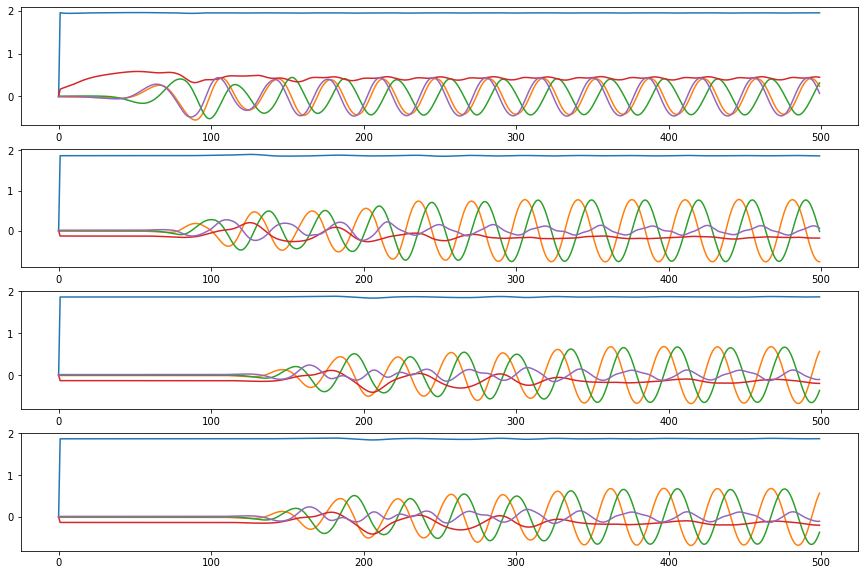

In [9]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(csv_data[0,:5,:500].T)
ax1 = fig.add_subplot(412)
ax1.plot(csv_data[1,:5,:500].T)
ax1 = fig.add_subplot(413)
ax1.plot(csv_data[2,:5,:500].T)
ax1 = fig.add_subplot(414)
ax1.plot(csv_data[2,:5,:500].T)

plt.show()

In [10]:
# Cutting the dataset
print(csv_data.shape)
csv_data = csv_data[:subdomains,:nPOD,start_from:start_from+datapoints]
print(csv_data.shape)

(4, 10, 2000)
(4, 10, 1853)


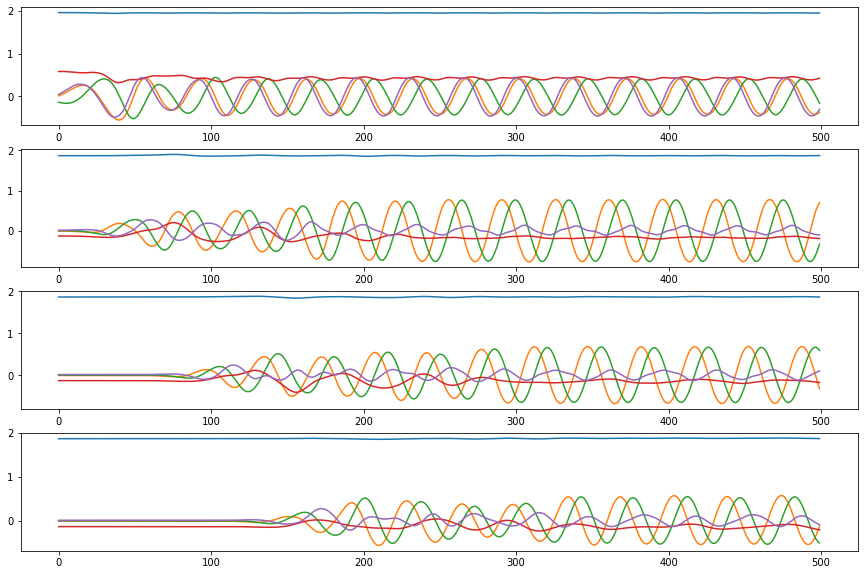

In [11]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(csv_data[0,:5,:500].T)
ax1 = fig.add_subplot(412)
ax1.plot(csv_data[1,:5,:500].T)
ax1 = fig.add_subplot(413)
ax1.plot(csv_data[2,:5,:500].T)
ax1 = fig.add_subplot(414)
ax1.plot(csv_data[3,:5,:500].T)

plt.show()

In [12]:
# Transposing data
tmp_data = np.ones([subdomains, datapoints, nPOD])

# Making a dataset for debugging purposes
new_data = np.ones([subdomains, nPOD, datapoints])
for i in range(subdomains):
    for j in range(nPOD):
        for k in range(datapoints):
            new_data[i][j][k] = nPOD*j + (i + 1)*10000 + k  

for k in range(subdomains):
    tmp_data[k] = csv_data[k].T
    if debug:
        tmp_data[k] = new_data[k].T
    
csv_data = tmp_data
csv_data.shape

(4, 1853, 10)

In [13]:
# Scaling
scales = []
scaled_training = np.zeros_like(csv_data)
if debug is False:
    for i in range(subdomains):
        scales.append(sklearn.preprocessing.MinMaxScaler(feature_range=[-1,1]))
        scaled_training[i] = scales[i].fit_transform(csv_data[i])
if debug:
    scaled_training = csv_data

In [14]:
# Asserting scaling is accurate
if debug is False:
    cond = np.zeros_like(scaled_training)
    for i in range(subdomains):
        cond[i] = scales[i].inverse_transform(scaled_training[i])
    assert np.allclose(csv_data[0,:,0], cond[0,:,0]), "Scaling failed"  

    for dim in range(subdomains):
        for icol in range(nPOD):
            assert np.isclose(np.min(scaled_training[dim][:,icol]) + np.max(scaled_training[dim][:,icol]), 0), "Scaling failed" 

In [15]:
# Setting up the data into subdomains 
# 2 x nTrain x nsteps * nPOD *3 # 'float32' or np.float32

assert sum(added_dims[:-1]) == cumulative_dims[-1]

training_data = np.zeros((evaluated_subdomains, t_end, np.sum(added_dims * nPOD)), dtype=np.float32) 

for domain in range(evaluated_subdomains): 
    for i, dim in enumerate([0,2,1]):
        for j, step in enumerate(range(steps-added_dims[i], steps)):
            training_data[domain, :, cumulative_dims[i]*nPOD + j*nPOD : cumulative_dims[i]*nPOD + (j+1)*nPOD] = scaled_training[dim + domain][t_begin+(step*step_size) : t_end+(step*step_size), :]

# Adding data for leftmost and rightmost domain
boundrary_conditions = []
boundrary_conditions.append(scaled_training[0, (steps-1)*step_size:])
boundrary_conditions.append(scaled_training[-1, (steps-1)*step_size:])

In [16]:
assert np.allclose(training_data[0,1,(added_dims[0]-1)*nPOD:added_dims[0]*nPOD], boundrary_conditions[0][1]), 'Check the boundrary condition data.'

In [17]:
joined_train_data = training_data.reshape((training_data.shape[1]*training_data.shape[0], training_data.shape[2]))

print(training_data.shape)
print(joined_train_data.shape)
print(tmp_data[0,steps-1:].shape)

(2, 1800, 50)
(3600, 50)
(1851, 10)


### Initializing GAN

In [18]:
kwargs = {
    "nsteps" : np.sum(added_dims),
    "ndims" : nPOD,
    "nLatent": nlatent,
    "batch_size" : 45,
    "batches" : 80,
    "seed" : 143,
    "epochs" : epochs,
    "noise" : noise,
    "n_gradient_ascent" : n_gradient_ascent,
    "logs_location" : './logs/gradient_tape/224/',
    "model_location" : 'models/224/'
}

gan = GAN(**kwargs)
gan.setup(find_old_model=find_old_model)
set_seed(gan.seed)

ndims_latent_input = gan.ndims
joined_train_data = np.float32(joined_train_data)
print('type and shape (nPOD by nTrain) of POD coeffs from csv file', type(joined_train_data), joined_train_data.shape, joined_train_data.dtype)

making new generator and critic
type and shape (nPOD by nTrain) of POD coeffs from csv file <class 'numpy.ndarray'> (3600, 50) float32


In [19]:
if train:
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir ./logs/gradient_tape/ --port 6008
    %reload_ext tensorboard

In [20]:
if train:
    gan.learn_hypersurface_from_POD_coeffs(joined_train_data)

beginning training
epoch: 	 0
gen loss:  -0.003502129 d loss:  9.416276 w_loss:  -0.0034189844
epoch: 	 1
gen loss:  -0.093927056 d loss:  4.0086107 w_loss:  -0.071389094
epoch: 	 2
gen loss:  -0.20623103 d loss:  2.441452 w_loss:  -0.08255083
epoch: 	 3
gen loss:  -0.2726206 d loss:  1.7004474 w_loss:  -0.053526897
epoch: 	 4
gen loss:  -0.3363252 d loss:  1.1590359 w_loss:  0.01622704
epoch: 	 5
gen loss:  -0.42274266 d loss:  0.9794698 w_loss:  0.09708945
epoch: 	 6
gen loss:  -0.5200102 d loss:  0.9142116 w_loss:  0.17225103
epoch: 	 7
gen loss:  -0.5869655 d loss:  1.0971346 w_loss:  0.26947063
epoch: 	 8
gen loss:  -0.6402488 d loss:  1.0428302 w_loss:  0.32881802
epoch: 	 9
gen loss:  -0.6883901 d loss:  1.1216261 w_loss:  0.3416614
epoch: 	 10
gen loss:  -0.7790322 d loss:  1.1292567 w_loss:  0.33635297
epoch: 	 11
gen loss:  -0.82123595 d loss:  1.2260156 w_loss:  0.31817567
epoch: 	 12
gen loss:  -0.85715324 d loss:  1.4950804 w_loss:  0.26723865
epoch: 	 13
gen loss:  -0.803

Time step: 	 0
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

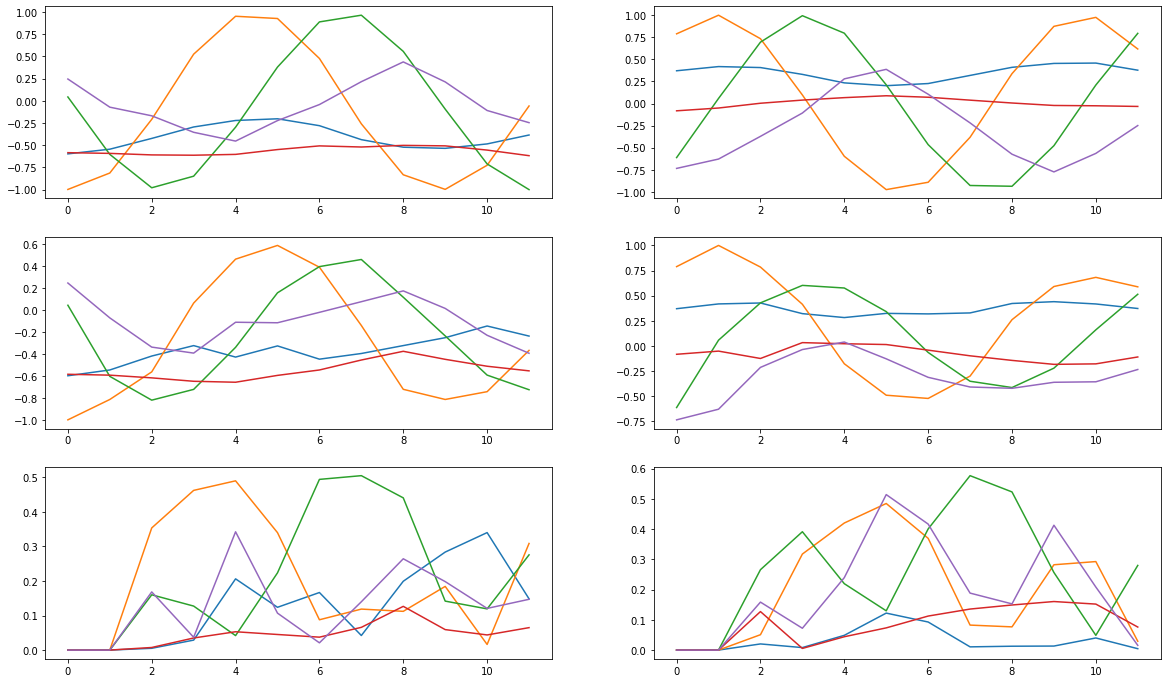

epoch: 	 0
gen loss:  0.7086263 d loss:  0.33453292 w_loss:  0.03647101
epoch: 	 1
gen loss:  0.7818181 d loss:  0.21570227 w_loss:  0.17546895
epoch: 	 2
gen loss:  0.7540506 d loss:  0.316186 w_loss:  0.069917664
epoch: 	 3
gen loss:  0.68924016 d loss:  0.3104121 w_loss:  0.101790465
epoch: 	 4
gen loss:  0.75723135 d loss:  0.2685991 w_loss:  0.110951796
epoch: 	 5
gen loss:  0.7430901 d loss:  0.28539675 w_loss:  0.10601369
epoch: 	 6
gen loss:  0.6686288 d loss:  0.27161795 w_loss:  0.12816228
epoch: 	 7
gen loss:  0.5502626 d loss:  0.254682 w_loss:  0.13125075
epoch: 	 8
gen loss:  0.47775516 d loss:  0.25408307 w_loss:  0.13095301
epoch: 	 9
gen loss:  0.42432767 d loss:  0.22858799 w_loss:  0.14384463
epoch: 	 10
gen loss:  0.38237497 d loss:  0.2360652 w_loss:  0.12882748
epoch: 	 11
gen loss:  0.40129885 d loss:  0.29352337 w_loss:  0.08114402
epoch: 	 12
gen loss:  0.4560922 d loss:  0.25955048 w_loss:  0.12648734
epoch: 	 13
gen loss:  0.41371194 d loss:  0.2766382 w_loss

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch:

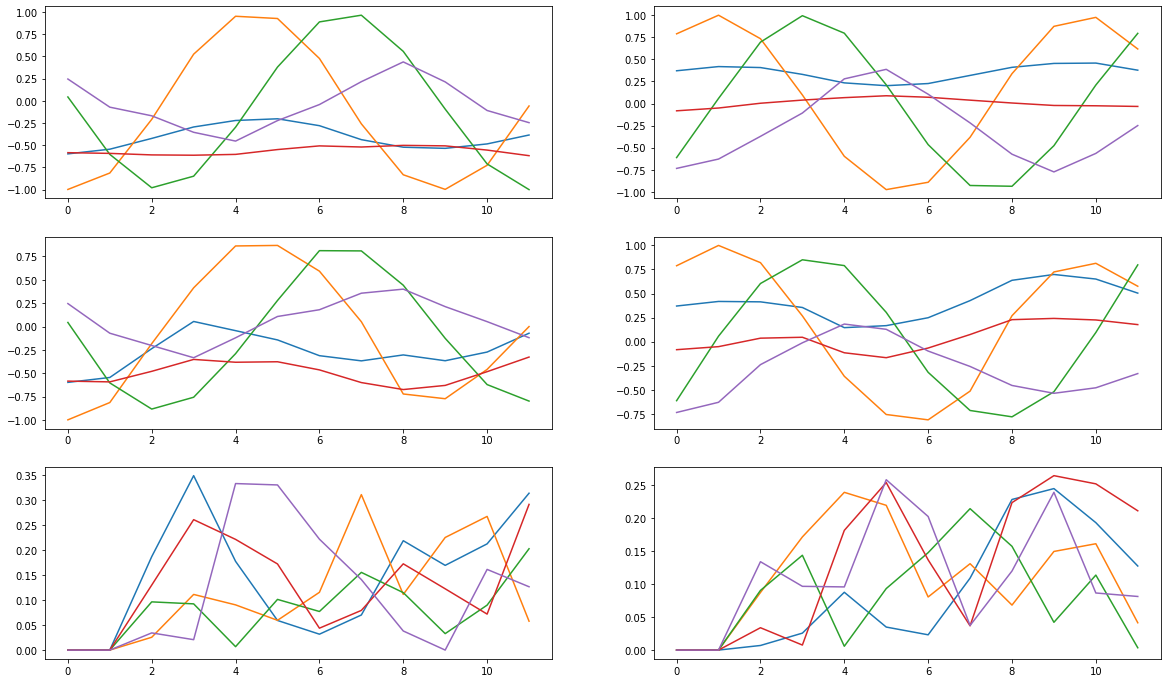

epoch: 	 0
gen loss:  0.3653258 d loss:  0.17073712 w_loss:  0.029676843
epoch: 	 1
gen loss:  0.37584925 d loss:  0.12782808 w_loss:  0.10748786
epoch: 	 2
gen loss:  0.49494272 d loss:  0.09780477 w_loss:  0.1237029
epoch: 	 3
gen loss:  0.35698545 d loss:  0.100890696 w_loss:  0.14356539
epoch: 	 4
gen loss:  0.36052352 d loss:  0.06420191 w_loss:  0.15270016
epoch: 	 5
gen loss:  0.3025762 d loss:  0.10402038 w_loss:  0.111251295
epoch: 	 6
gen loss:  0.28820336 d loss:  0.16047074 w_loss:  0.04981238
epoch: 	 7
gen loss:  0.33143908 d loss:  0.09000005 w_loss:  0.11300663
epoch: 	 8
gen loss:  0.27921534 d loss:  0.13859317 w_loss:  0.064768314
epoch: 	 9
gen loss:  0.27677542 d loss:  0.15614955 w_loss:  0.0668868
epoch: 	 10
gen loss:  0.25430202 d loss:  0.16877091 w_loss:  0.041573174
epoch: 	 11
gen loss:  0.36122763 d loss:  0.12484624 w_loss:  0.0984586
epoch: 	 12
gen loss:  0.3580672 d loss:  0.13541241 w_loss:  0.0808839
epoch: 	 13
gen loss:  0.44110483 d loss:  0.11909

Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
O

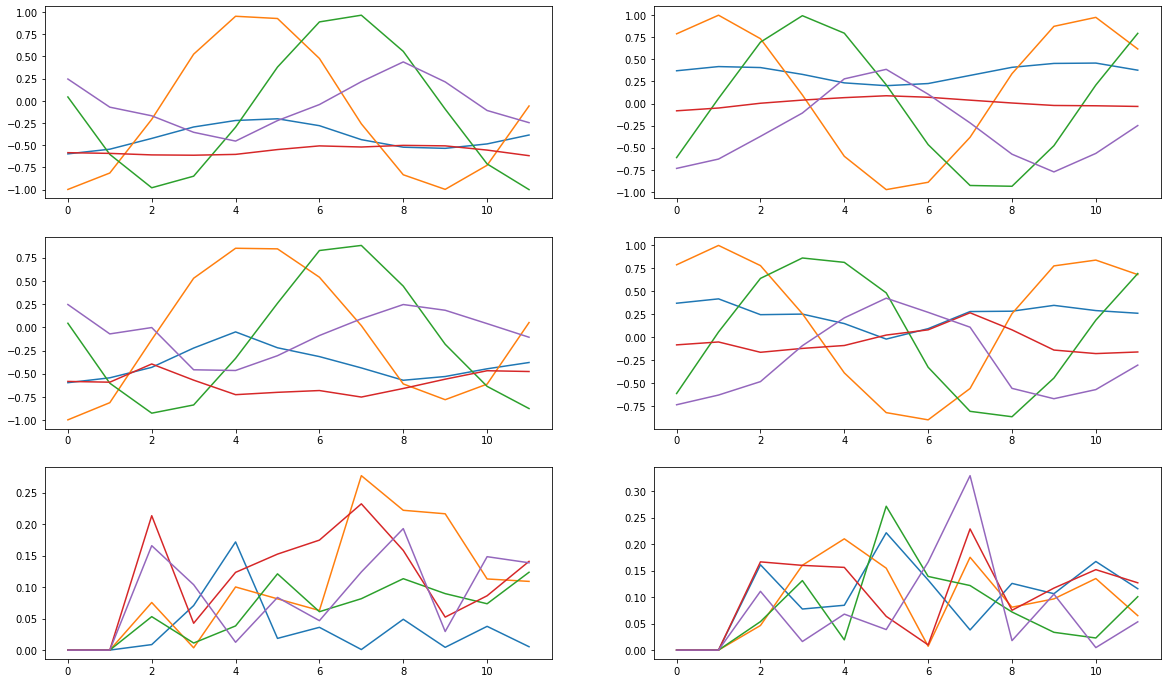

epoch: 	 0
gen loss:  0.34845668 d loss:  0.07873352 w_loss:  0.078359015
epoch: 	 1
gen loss:  0.25643417 d loss:  0.1075722 w_loss:  0.048598133
epoch: 	 2
gen loss:  0.21301131 d loss:  0.12591857 w_loss:  0.028078556
epoch: 	 3
gen loss:  0.2899683 d loss:  0.12246545 w_loss:  0.026235074
epoch: 	 4
gen loss:  0.27177384 d loss:  0.1371846 w_loss:  -0.008473205
epoch: 	 5
gen loss:  0.32372445 d loss:  0.15476468 w_loss:  0.00013897047
epoch: 	 6
gen loss:  0.3320939 d loss:  0.05565563 w_loss:  0.087781
epoch: 	 7
gen loss:  0.33612427 d loss:  0.14259699 w_loss:  0.0002722416
epoch: 	 8
gen loss:  0.3673502 d loss:  0.098274514 w_loss:  0.038565207
epoch: 	 9
gen loss:  0.2846719 d loss:  0.05417016 w_loss:  0.08371354
epoch: 	 10
gen loss:  0.30226886 d loss:  0.12201147 w_loss:  0.026262846
epoch: 	 11
gen loss:  0.29707333 d loss:  0.09130276 w_loss:  0.06363679
epoch: 	 12
gen loss:  0.29218197 d loss:  0.1116725 w_loss:  0.033189073
epoch: 	 13
gen loss:  0.31413817 d loss: 

Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

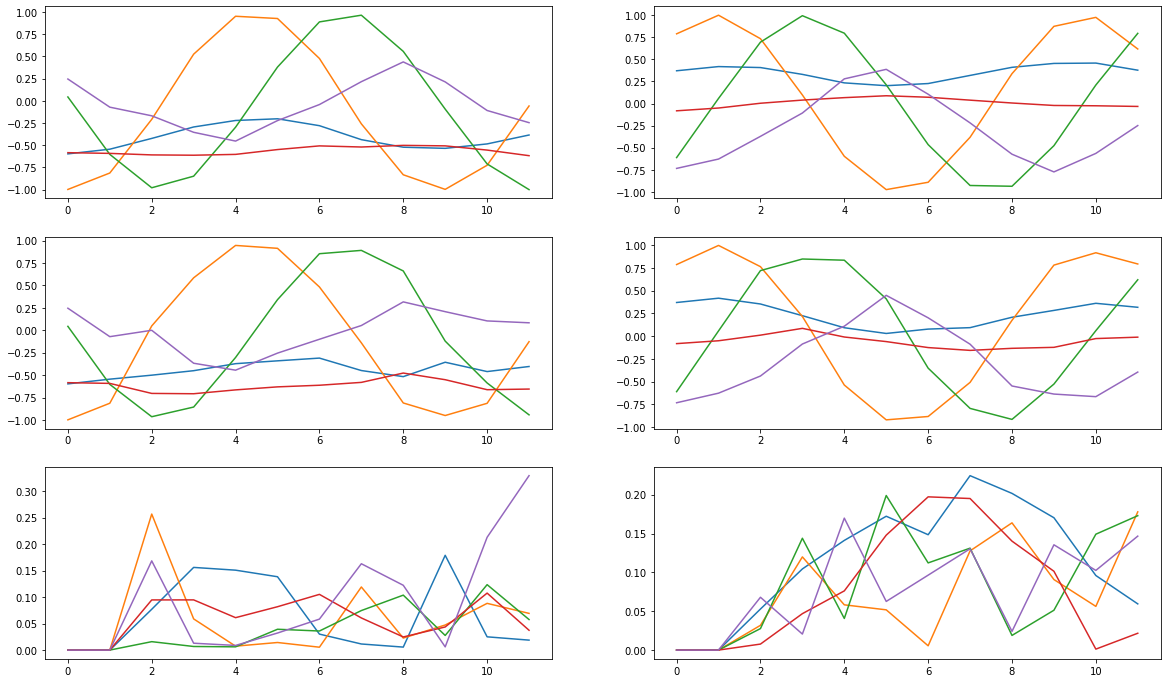

epoch: 	 0
gen loss:  0.20494299 d loss:  0.123166226 w_loss:  0.029199878
epoch: 	 1
gen loss:  0.29982516 d loss:  0.09311192 w_loss:  0.050150655
epoch: 	 2
gen loss:  0.25196993 d loss:  0.055953622 w_loss:  0.07811657
epoch: 	 3
gen loss:  0.25422928 d loss:  0.1331895 w_loss:  0.018127944
epoch: 	 4
gen loss:  0.20672925 d loss:  0.11693221 w_loss:  0.02882441
epoch: 	 5
gen loss:  0.260194 d loss:  0.075508095 w_loss:  0.05738949
epoch: 	 6
gen loss:  0.29152945 d loss:  0.13030912 w_loss:  0.04143273
epoch: 	 7
gen loss:  0.25801092 d loss:  0.11915277 w_loss:  0.04203167
epoch: 	 8
gen loss:  0.24235268 d loss:  0.036524884 w_loss:  0.101905644
epoch: 	 9
gen loss:  0.27652925 d loss:  0.09110393 w_loss:  0.056831963
epoch: 	 10
gen loss:  0.23766801 d loss:  0.13211718 w_loss:  0.014180665
epoch: 	 11
gen loss:  0.2835128 d loss:  0.13792855 w_loss:  0.013407464
epoch: 	 12
gen loss:  0.2776528 d loss:  0.15798107 w_loss:  -0.011997366
epoch: 	 13
gen loss:  0.21827047 d loss

Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
O

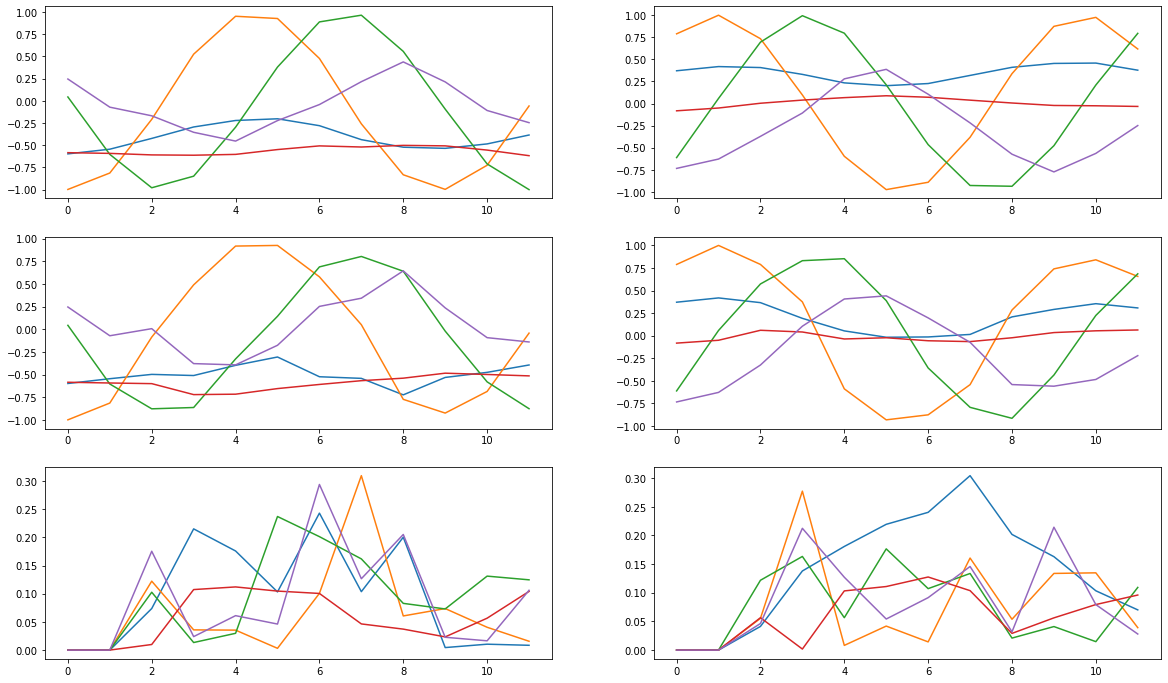

epoch: 	 0
gen loss:  0.09130245 d loss:  0.10226335 w_loss:  0.04521147
epoch: 	 1
gen loss:  0.07979928 d loss:  0.08298316 w_loss:  0.052171897
epoch: 	 2
gen loss:  0.16205797 d loss:  0.1244546 w_loss:  0.014241265
epoch: 	 3
gen loss:  0.140778 d loss:  0.104981065 w_loss:  0.032785658
epoch: 	 4
gen loss:  0.17674422 d loss:  0.09246038 w_loss:  0.034105
epoch: 	 5
gen loss:  0.18458006 d loss:  0.14271694 w_loss:  0.0023762062
epoch: 	 6
gen loss:  0.15671125 d loss:  0.035777427 w_loss:  0.08437459
epoch: 	 7
gen loss:  0.12008268 d loss:  0.107264 w_loss:  0.026884073
epoch: 	 8
gen loss:  0.15907416 d loss:  0.0878375 w_loss:  0.049629454
epoch: 	 9
gen loss:  0.15508258 d loss:  0.15125754 w_loss:  -0.011769864
epoch: 	 10
gen loss:  0.07139264 d loss:  -0.009996235 w_loss:  0.1587158
epoch: 	 11
gen loss:  0.16430978 d loss:  0.13483873 w_loss:  0.012208639
epoch: 	 12
gen loss:  0.12340812 d loss:  0.14888501 w_loss:  -0.020843461
epoch: 	 13
gen loss:  0.14081302 d loss:

Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epo

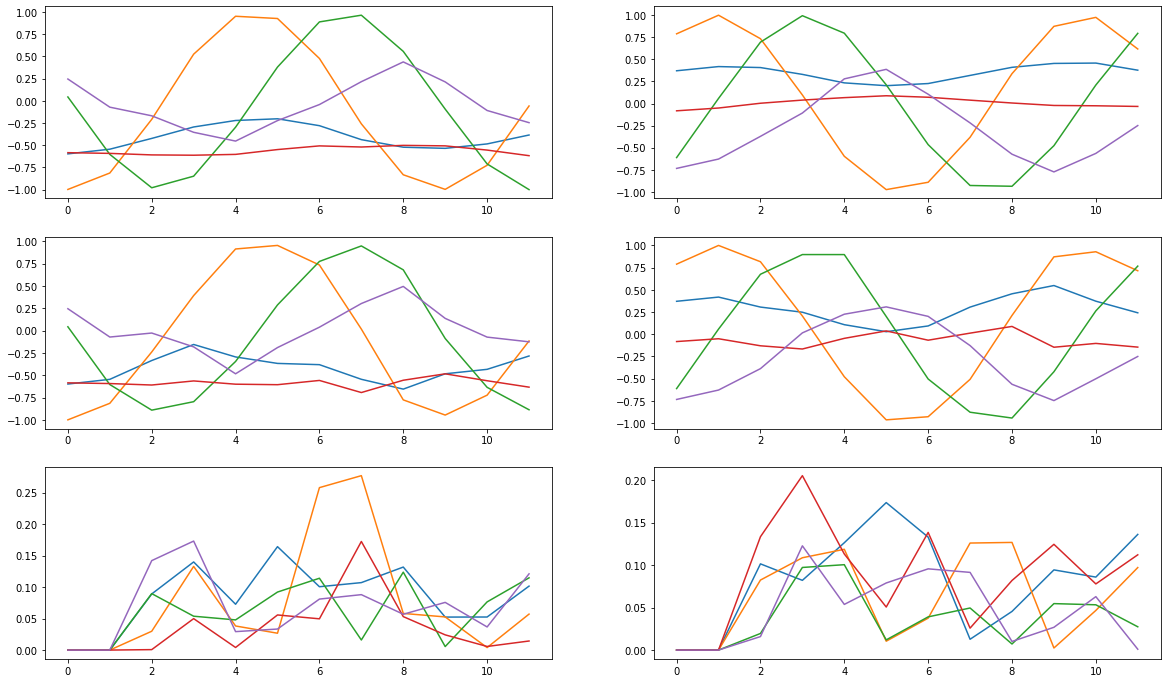

epoch: 	 0
gen loss:  0.44554296 d loss:  0.028475061 w_loss:  0.06803252
epoch: 	 1
gen loss:  0.4348492 d loss:  0.02639318 w_loss:  0.0659757
epoch: 	 2
gen loss:  0.44142628 d loss:  0.08134784 w_loss:  0.017421046
epoch: 	 3
gen loss:  0.42212963 d loss:  0.08423946 w_loss:  0.0079059545
epoch: 	 4
gen loss:  0.4437251 d loss:  0.042133458 w_loss:  0.055690806
epoch: 	 5
gen loss:  0.55448705 d loss:  -0.0025732394 w_loss:  0.08373903
epoch: 	 6
gen loss:  0.5212663 d loss:  0.10099129 w_loss:  -0.0033938275
epoch: 	 7
gen loss:  0.5424495 d loss:  0.04118108 w_loss:  0.06381156
epoch: 	 8
gen loss:  0.44830188 d loss:  0.0364918 w_loss:  0.053640198
epoch: 	 9
gen loss:  0.51354593 d loss:  0.04551694 w_loss:  0.049692236
epoch: 	 10
gen loss:  0.4889275 d loss:  -0.0030233178 w_loss:  0.106625065
epoch: 	 11
gen loss:  0.55764985 d loss:  0.07591176 w_loss:  0.016161237
epoch: 	 12
gen loss:  0.51176417 d loss:  0.033064533 w_loss:  0.066838756
epoch: 	 13
gen loss:  0.5182839 d

Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
O

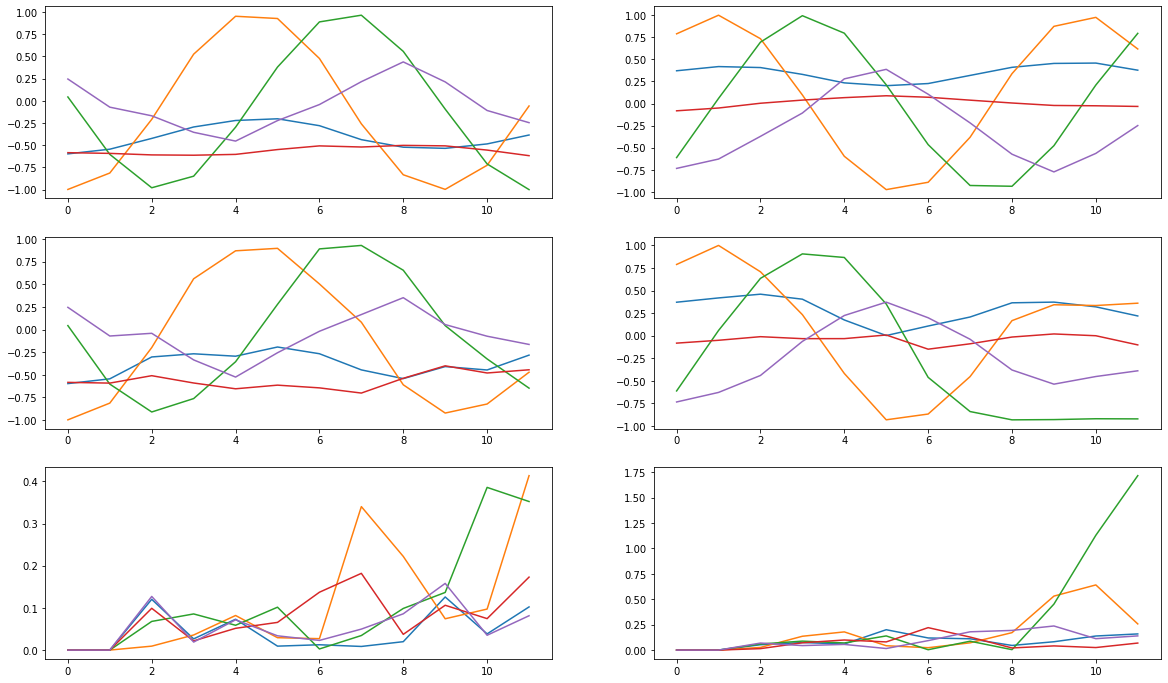

epoch: 	 0
gen loss:  0.6757769 d loss:  0.052598648 w_loss:  0.03957521
epoch: 	 1
gen loss:  0.6818246 d loss:  0.029406423 w_loss:  0.060333155
epoch: 	 2
gen loss:  0.5790379 d loss:  0.109012045 w_loss:  -0.003319605
epoch: 	 3
gen loss:  0.6791272 d loss:  0.007891709 w_loss:  0.07535426
epoch: 	 4
gen loss:  0.707518 d loss:  0.063188225 w_loss:  0.017197773
epoch: 	 5
gen loss:  0.6807967 d loss:  0.05251045 w_loss:  0.046821374
epoch: 	 6
gen loss:  0.68085057 d loss:  0.06153792 w_loss:  0.04272857
epoch: 	 7
gen loss:  0.594311 d loss:  0.019811125 w_loss:  0.069391206
epoch: 	 8
gen loss:  0.588832 d loss:  0.096708015 w_loss:  0.0016773834
epoch: 	 9
gen loss:  0.6720711 d loss:  0.03229585 w_loss:  0.057778895
epoch: 	 10
gen loss:  0.6378607 d loss:  0.041307446 w_loss:  0.043831512
epoch: 	 11
gen loss:  0.6915714 d loss:  0.075994805 w_loss:  0.030441588
epoch: 	 12
gen loss:  0.6329052 d loss:  0.07040357 w_loss:  0.025926432
epoch: 	 13
gen loss:  0.6258823 d loss:  

Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
O

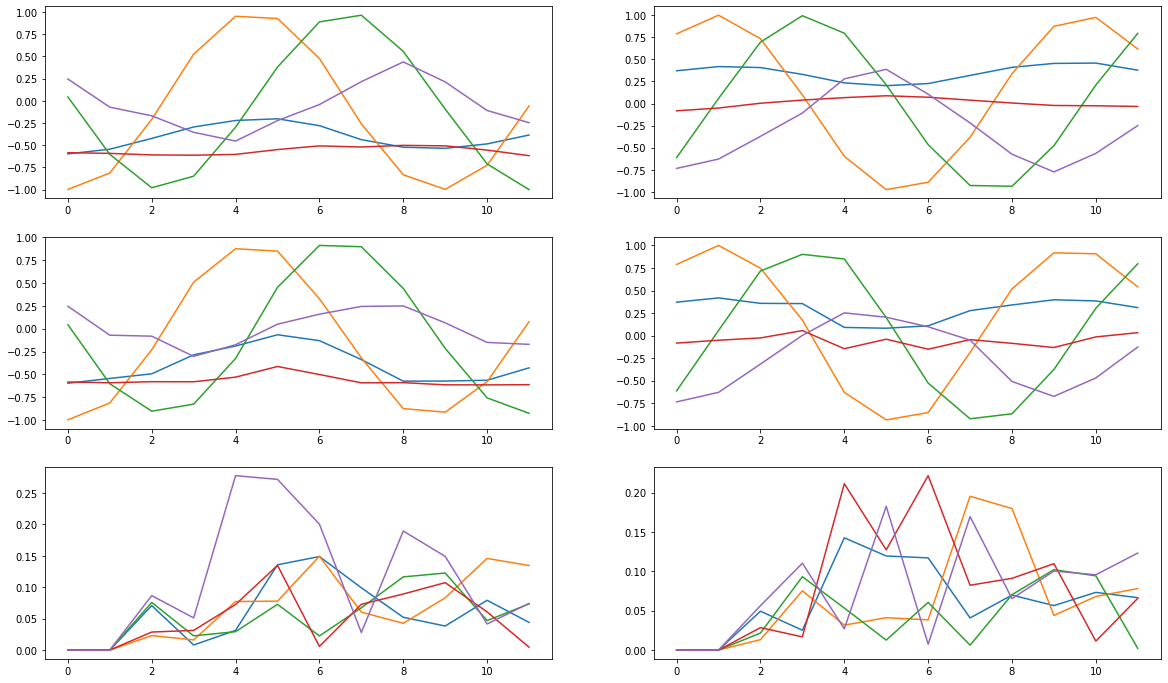

epoch: 	 0
gen loss:  0.5872797 d loss:  0.022266507 w_loss:  0.07271745
epoch: 	 1
gen loss:  0.6444788 d loss:  0.06997821 w_loss:  0.02568907
epoch: 	 2
gen loss:  0.65008557 d loss:  0.01876711 w_loss:  0.071040764
epoch: 	 3
gen loss:  0.61997575 d loss:  0.05523035 w_loss:  0.021620506
epoch: 	 4
gen loss:  0.5788308 d loss:  0.08453996 w_loss:  0.022412296
epoch: 	 5
gen loss:  0.58728904 d loss:  0.114498995 w_loss:  -0.026562527
epoch: 	 6
gen loss:  0.5184957 d loss:  0.050837517 w_loss:  0.04538811
epoch: 	 7
gen loss:  0.57647294 d loss:  0.051805146 w_loss:  0.053565394
epoch: 	 8
gen loss:  0.6129483 d loss:  0.030741856 w_loss:  0.06280164
epoch: 	 9
gen loss:  0.628572 d loss:  0.04507963 w_loss:  0.056865804
epoch: 	 10
gen loss:  0.54926616 d loss:  0.04958815 w_loss:  0.05111588
epoch: 	 11
gen loss:  0.6164812 d loss:  0.051473342 w_loss:  0.038038578
epoch: 	 12
gen loss:  0.6486102 d loss:  0.082047366 w_loss:  0.007750942
epoch: 	 13
gen loss:  0.7460935 d loss: 

Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
O

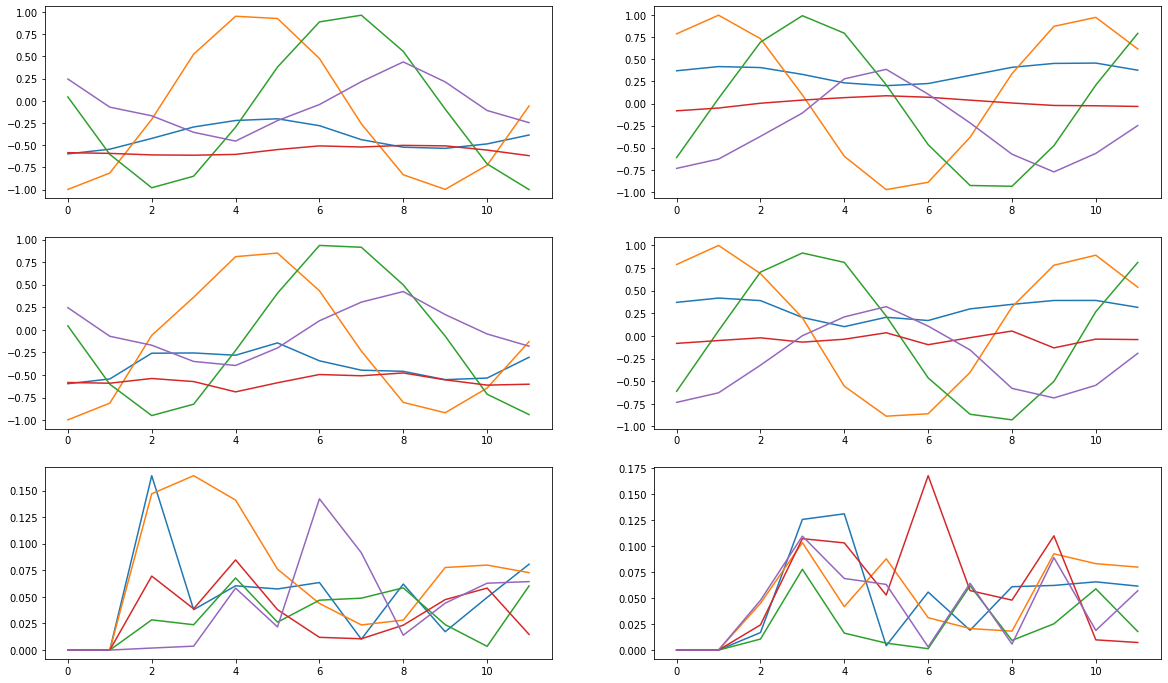

epoch: 	 0
gen loss:  0.79257816 d loss:  0.024134764 w_loss:  0.06699576
epoch: 	 1
gen loss:  0.7114154 d loss:  0.08349091 w_loss:  0.017819226
epoch: 	 2
gen loss:  0.6828596 d loss:  0.007128954 w_loss:  0.0780609
epoch: 	 3
gen loss:  0.6579447 d loss:  0.014846544 w_loss:  0.06963418
epoch: 	 4
gen loss:  0.68448937 d loss:  0.013395538 w_loss:  0.07081455
epoch: 	 5
gen loss:  0.6787927 d loss:  0.042725764 w_loss:  0.051261745
epoch: 	 6
gen loss:  0.62703085 d loss:  0.02491043 w_loss:  0.045510367
epoch: 	 7
gen loss:  0.65402347 d loss:  0.053523373 w_loss:  0.033272207
epoch: 	 8
gen loss:  0.6346404 d loss:  0.024525395 w_loss:  0.048625343
epoch: 	 9
gen loss:  0.64393955 d loss:  0.012123886 w_loss:  0.0859782
epoch: 	 10
gen loss:  0.6468947 d loss:  0.13828522 w_loss:  -0.049275663
epoch: 	 11
gen loss:  0.68287575 d loss:  0.06297572 w_loss:  0.024583481
epoch: 	 12
gen loss:  0.6914345 d loss:  0.120129265 w_loss:  -0.018257087
epoch: 	 13
gen loss:  0.6512287 d los

Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
O

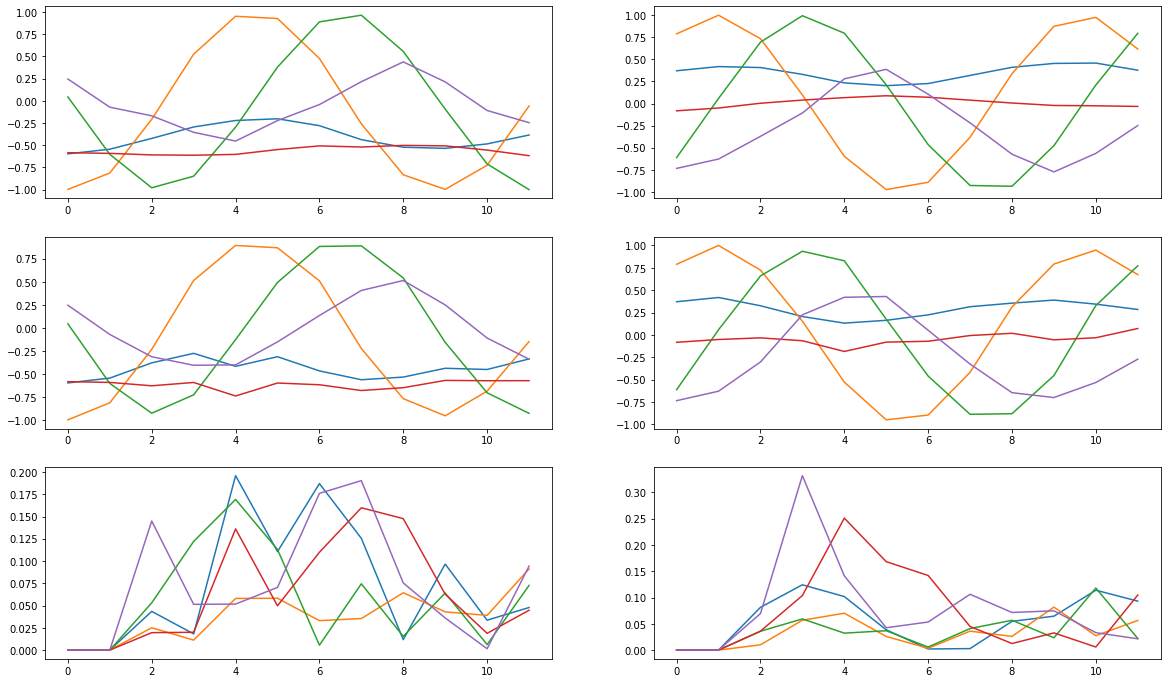

epoch: 	 0
gen loss:  0.6209264 d loss:  0.078754835 w_loss:  0.014308937
epoch: 	 1
gen loss:  0.64944685 d loss:  0.02845242 w_loss:  0.05057203
epoch: 	 2
gen loss:  0.64405525 d loss:  0.07019627 w_loss:  0.023936342
epoch: 	 3
gen loss:  0.650221 d loss:  0.072540745 w_loss:  0.017487505
epoch: 	 4
gen loss:  0.64804155 d loss:  0.056541663 w_loss:  0.023252634
epoch: 	 5
gen loss:  0.63553226 d loss:  0.0021544439 w_loss:  0.084892094
epoch: 	 6
gen loss:  0.67528063 d loss:  0.09745419 w_loss:  0.006156036
epoch: 	 7
gen loss:  0.6430331 d loss:  0.04724251 w_loss:  0.028588062
epoch: 	 8
gen loss:  0.6402367 d loss:  0.06574112 w_loss:  0.03530443
epoch: 	 9
gen loss:  0.6682475 d loss:  0.08811154 w_loss:  0.005154408
epoch: 	 10
gen loss:  0.722612 d loss:  0.040802106 w_loss:  0.05314963
epoch: 	 11
gen loss:  0.671894 d loss:  0.04716808 w_loss:  0.04137991
epoch: 	 12
gen loss:  0.706745 d loss:  0.047656856 w_loss:  0.038043164
epoch: 	 13
gen loss:  0.6529535 d loss:  0.

Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

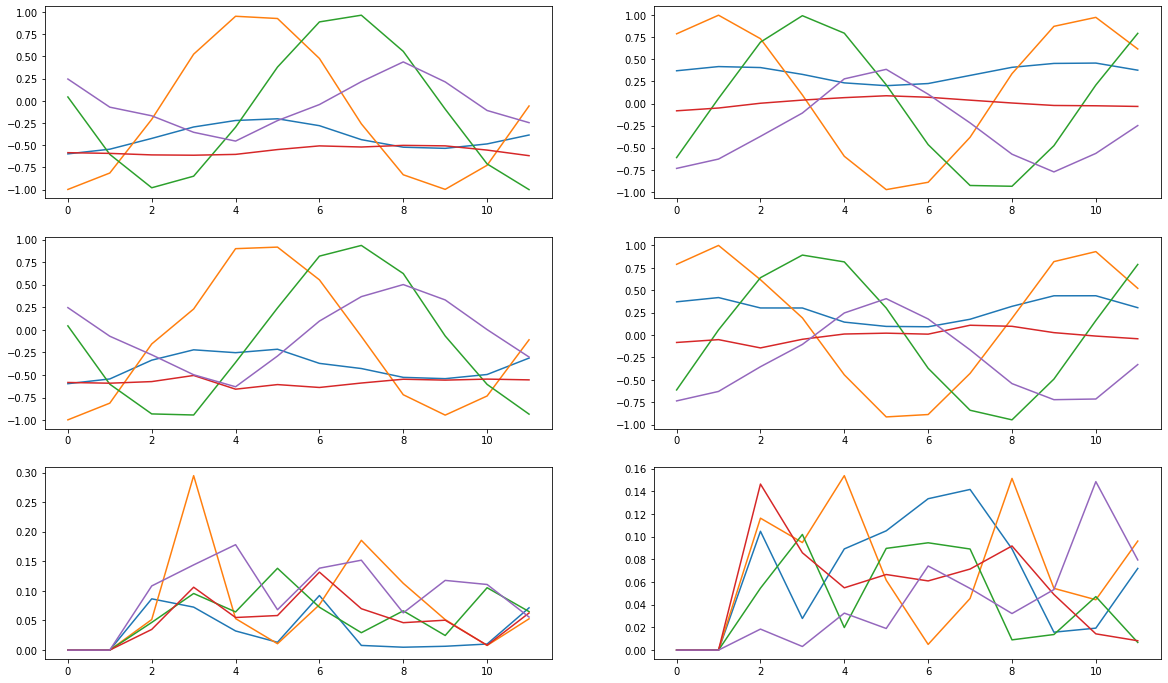

epoch: 	 0
gen loss:  0.7111413 d loss:  0.053760745 w_loss:  0.029331539
epoch: 	 1
gen loss:  0.6822503 d loss:  0.11037327 w_loss:  -0.010804407
epoch: 	 2
gen loss:  0.7023775 d loss:  0.035154454 w_loss:  0.05187134
epoch: 	 3
gen loss:  0.70641977 d loss:  0.09544788 w_loss:  -0.020054081
epoch: 	 4
gen loss:  0.67872655 d loss:  0.078410335 w_loss:  0.010884983
epoch: 	 5
gen loss:  0.7079624 d loss:  0.07684098 w_loss:  0.028675398
epoch: 	 6
gen loss:  0.71985346 d loss:  0.09029649 w_loss:  -0.012605635
epoch: 	 7
gen loss:  0.71807283 d loss:  0.10288526 w_loss:  -0.01637008
epoch: 	 8
gen loss:  0.7040679 d loss:  0.059116177 w_loss:  0.022064084
epoch: 	 9
gen loss:  0.73451 d loss:  0.07050395 w_loss:  0.03127633
epoch: 	 10
gen loss:  0.71863043 d loss:  0.052190136 w_loss:  0.029088598
epoch: 	 11
gen loss:  0.67460537 d loss:  0.06713202 w_loss:  0.0244564
epoch: 	 12
gen loss:  0.7140025 d loss:  0.019417148 w_loss:  0.0648932
epoch: 	 13
gen loss:  0.7218572 d loss: 

Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
O

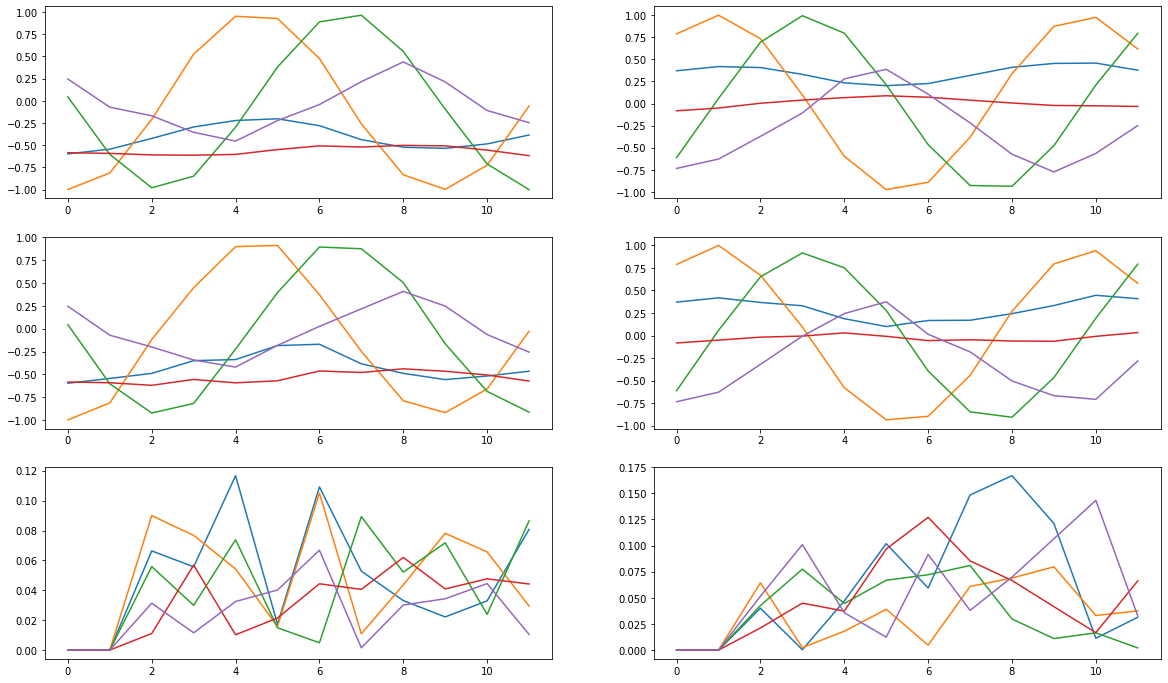

epoch: 	 0
gen loss:  0.76578486 d loss:  0.102904335 w_loss:  -0.014805716
epoch: 	 1
gen loss:  0.7402073 d loss:  0.036657203 w_loss:  0.067359075
epoch: 	 2
gen loss:  0.68334407 d loss:  0.016541548 w_loss:  0.07140331
epoch: 	 3
gen loss:  0.689479 d loss:  0.026430383 w_loss:  0.05525018
epoch: 	 4
gen loss:  0.7038114 d loss:  0.07248335 w_loss:  0.008467012
epoch: 	 5
gen loss:  0.7205354 d loss:  0.05113871 w_loss:  0.031582136
epoch: 	 6
gen loss:  0.6939426 d loss:  0.014899609 w_loss:  0.066552155
epoch: 	 7
gen loss:  0.7138426 d loss:  0.05070433 w_loss:  0.023057628
epoch: 	 8
gen loss:  0.7155523 d loss:  0.085826464 w_loss:  0.018731955
epoch: 	 9
gen loss:  0.7415221 d loss:  0.05515486 w_loss:  0.043026794
epoch: 	 10
gen loss:  0.7792574 d loss:  0.020848 w_loss:  0.079129584
epoch: 	 11
gen loss:  0.76561344 d loss:  0.08182264 w_loss:  0.020221421
epoch: 	 12
gen loss:  0.7365704 d loss:  0.0020838673 w_loss:  0.07960796
epoch: 	 13
gen loss:  0.7050996 d loss:  

Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

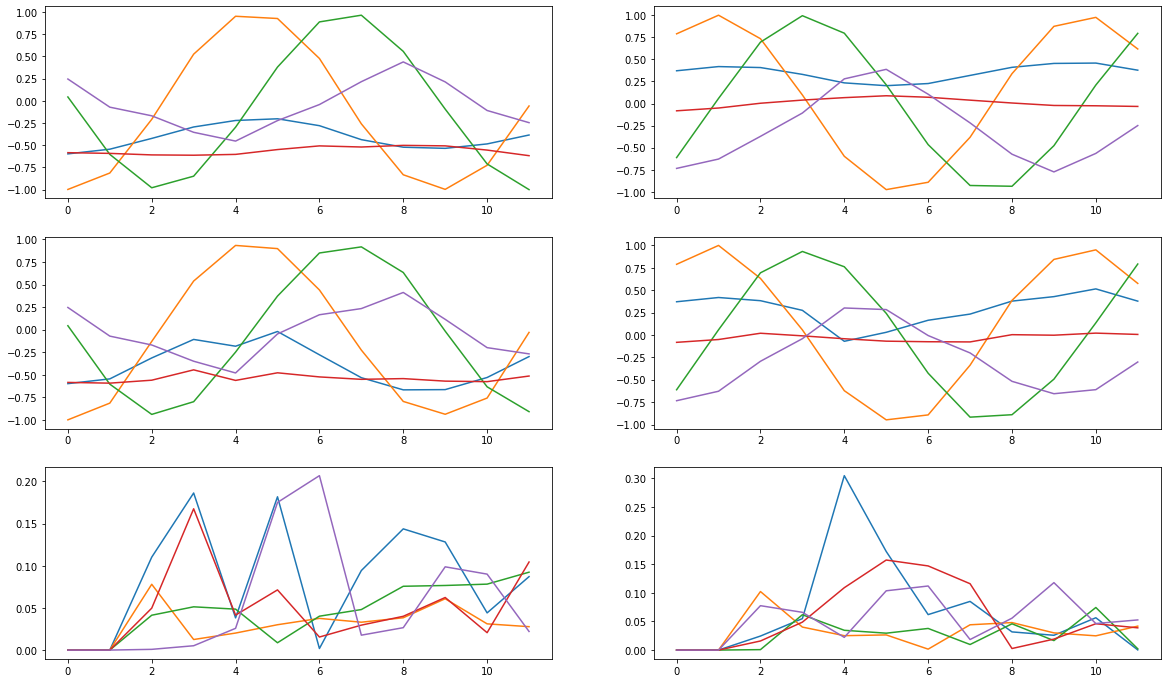

epoch: 	 0
gen loss:  0.6588241 d loss:  0.0896788 w_loss:  0.010076698
epoch: 	 1
gen loss:  0.686543 d loss:  0.11427345 w_loss:  -0.023216974
epoch: 	 2
gen loss:  0.7498764 d loss:  0.038590822 w_loss:  0.05075093
epoch: 	 3
gen loss:  0.7580804 d loss:  0.08099355 w_loss:  0.0037756884
epoch: 	 4
gen loss:  0.80200255 d loss:  0.041939437 w_loss:  0.048721276
epoch: 	 5
gen loss:  0.7970442 d loss:  0.035826378 w_loss:  0.05677095
epoch: 	 6
gen loss:  0.7611387 d loss:  0.11997409 w_loss:  -0.027525717
epoch: 	 7
gen loss:  0.8377263 d loss:  0.12990116 w_loss:  -0.035525125
epoch: 	 8
gen loss:  0.7781477 d loss:  0.021514269 w_loss:  0.06550732
epoch: 	 9
gen loss:  0.75181895 d loss:  0.016062835 w_loss:  0.07528126
epoch: 	 10
gen loss:  0.80072117 d loss:  0.046095967 w_loss:  0.04396803
epoch: 	 11
gen loss:  0.73970777 d loss:  0.0060429466 w_loss:  0.07819089
epoch: 	 12
gen loss:  0.80214435 d loss:  0.102533735 w_loss:  -0.008542986
epoch: 	 13
gen loss:  0.82840616 d l

Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
O

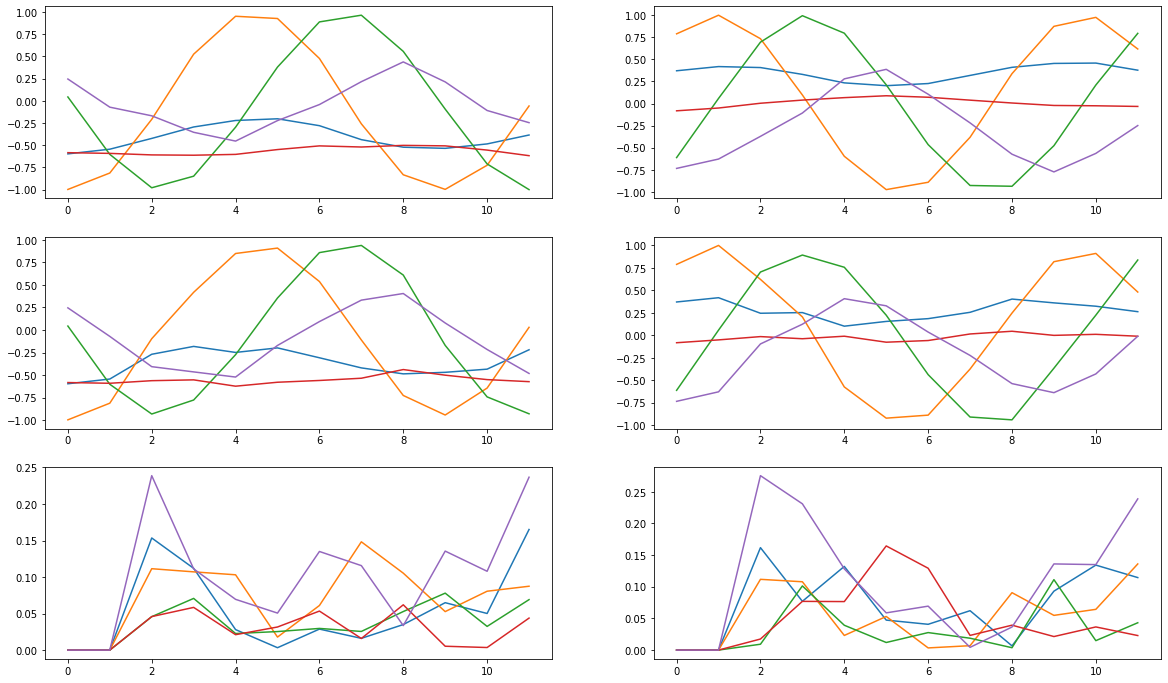

epoch: 	 0
gen loss:  0.7795659 d loss:  0.075501986 w_loss:  0.012552793
epoch: 	 1
gen loss:  0.84715414 d loss:  0.0630662 w_loss:  0.03486875
epoch: 	 2
gen loss:  0.84890825 d loss:  0.094814755 w_loss:  0.0039360723
epoch: 	 3
gen loss:  0.8063401 d loss:  0.09822548 w_loss:  -0.0013334311
epoch: 	 4
gen loss:  0.7626598 d loss:  0.1015185 w_loss:  0.013352898
epoch: 	 5
gen loss:  0.78747076 d loss:  0.03614236 w_loss:  0.047277678
epoch: 	 6
gen loss:  0.7184483 d loss:  0.08975425 w_loss:  -0.006433729
epoch: 	 7
gen loss:  0.7970705 d loss:  0.11203233 w_loss:  -0.018446382
epoch: 	 8
gen loss:  0.78852504 d loss:  0.03162631 w_loss:  0.059957378
epoch: 	 9
gen loss:  0.7668053 d loss:  0.08124779 w_loss:  0.0025350102
epoch: 	 10
gen loss:  0.7699512 d loss:  0.023284804 w_loss:  0.07679471
epoch: 	 11
gen loss:  0.723671 d loss:  0.04679625 w_loss:  0.032687936
epoch: 	 12
gen loss:  0.72043455 d loss:  0.06638865 w_loss:  0.028052304
epoch: 	 13
gen loss:  0.7408125 d loss

Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

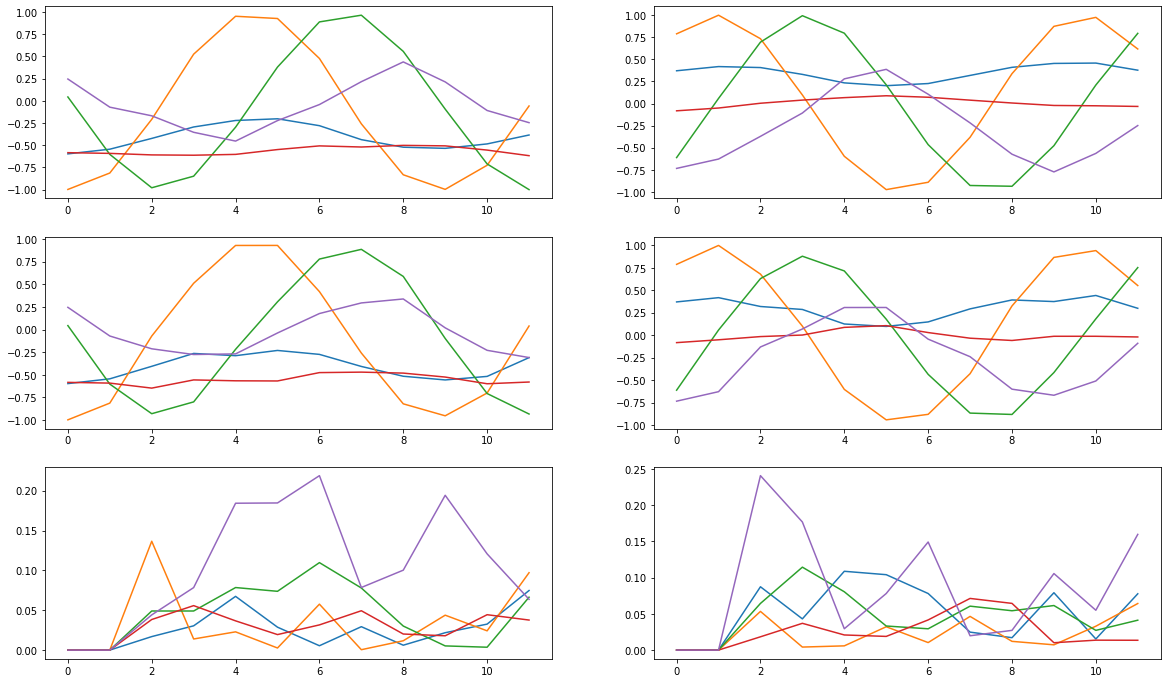

epoch: 	 0
gen loss:  0.765616 d loss:  0.07910648 w_loss:  0.010257488
epoch: 	 1
gen loss:  0.8126446 d loss:  0.056588374 w_loss:  0.037020378
epoch: 	 2
gen loss:  0.76763105 d loss:  0.019055957 w_loss:  0.06515704
epoch: 	 3
gen loss:  0.79739153 d loss:  0.08218874 w_loss:  0.009773089
epoch: 	 4
gen loss:  0.7783531 d loss:  0.03671501 w_loss:  0.04378914
epoch: 	 5
gen loss:  0.75135255 d loss:  0.0420138 w_loss:  0.055862714
epoch: 	 6
gen loss:  0.7280176 d loss:  0.08384206 w_loss:  0.019332048
epoch: 	 7
gen loss:  0.73741513 d loss:  0.08660728 w_loss:  0.0006772067
epoch: 	 8
gen loss:  0.803798 d loss:  0.043951645 w_loss:  0.043762457
epoch: 	 9
gen loss:  0.70092 d loss:  0.08313688 w_loss:  0.015062265
epoch: 	 10
gen loss:  0.6872923 d loss:  0.0075153275 w_loss:  0.08014073
epoch: 	 11
gen loss:  0.6920939 d loss:  0.058447443 w_loss:  0.039030872
epoch: 	 12
gen loss:  0.67284554 d loss:  0.06383862 w_loss:  0.017521342
epoch: 	 13
gen loss:  0.70499384 d loss:  0

Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
O

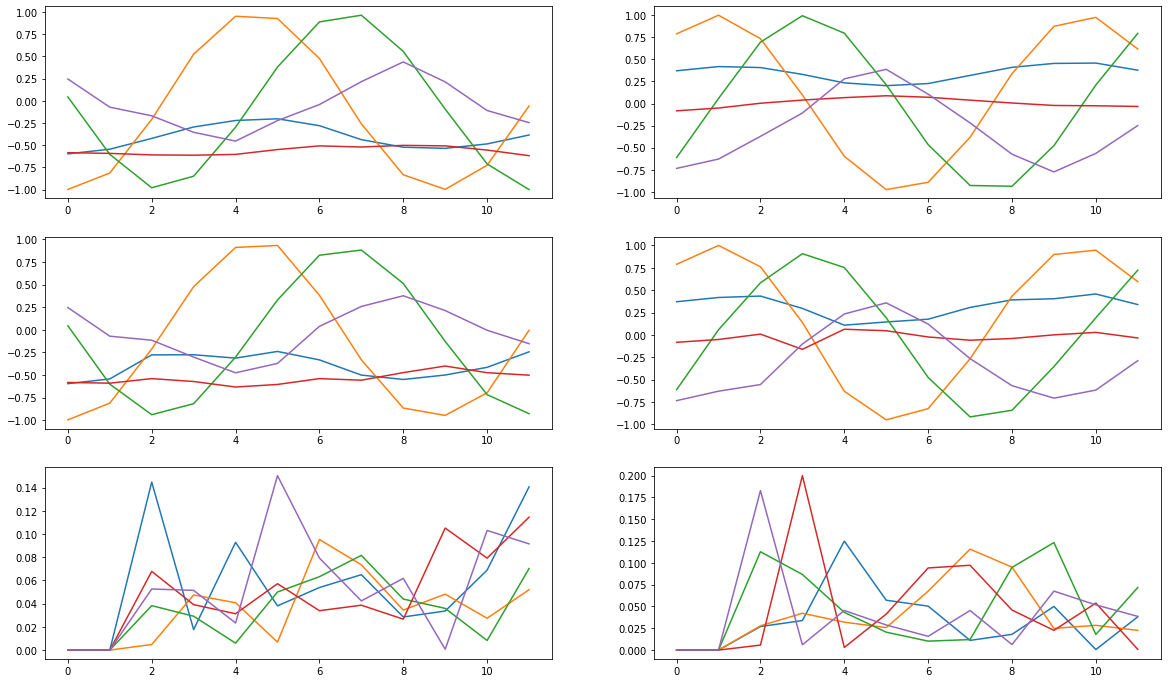

epoch: 	 0
gen loss:  0.5895269 d loss:  0.0761516 w_loss:  0.015028179
epoch: 	 1
gen loss:  0.64654315 d loss:  0.09565957 w_loss:  0.0023031253
epoch: 	 2
gen loss:  0.6390115 d loss:  0.075595215 w_loss:  0.012422508
epoch: 	 3
gen loss:  0.65879786 d loss:  0.05465885 w_loss:  0.040520746
epoch: 	 4
gen loss:  0.7363188 d loss:  0.057839464 w_loss:  0.036163412
epoch: 	 5
gen loss:  0.739845 d loss:  0.018148895 w_loss:  0.06862355
epoch: 	 6
gen loss:  0.751637 d loss:  0.062912025 w_loss:  0.04176549
epoch: 	 7
gen loss:  0.74160707 d loss:  0.029705882 w_loss:  0.061841756
epoch: 	 8
gen loss:  0.75082946 d loss:  0.11193506 w_loss:  -0.015720725
epoch: 	 9
gen loss:  0.76327735 d loss:  0.06184124 w_loss:  0.009880223
epoch: 	 10
gen loss:  0.79633176 d loss:  0.027760455 w_loss:  0.045996442
epoch: 	 11
gen loss:  0.80906993 d loss:  0.035808858 w_loss:  0.04744653
epoch: 	 12
gen loss:  0.73207617 d loss:  0.03113235 w_loss:  0.046355322
epoch: 	 13
gen loss:  0.70052564 d l

Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
O

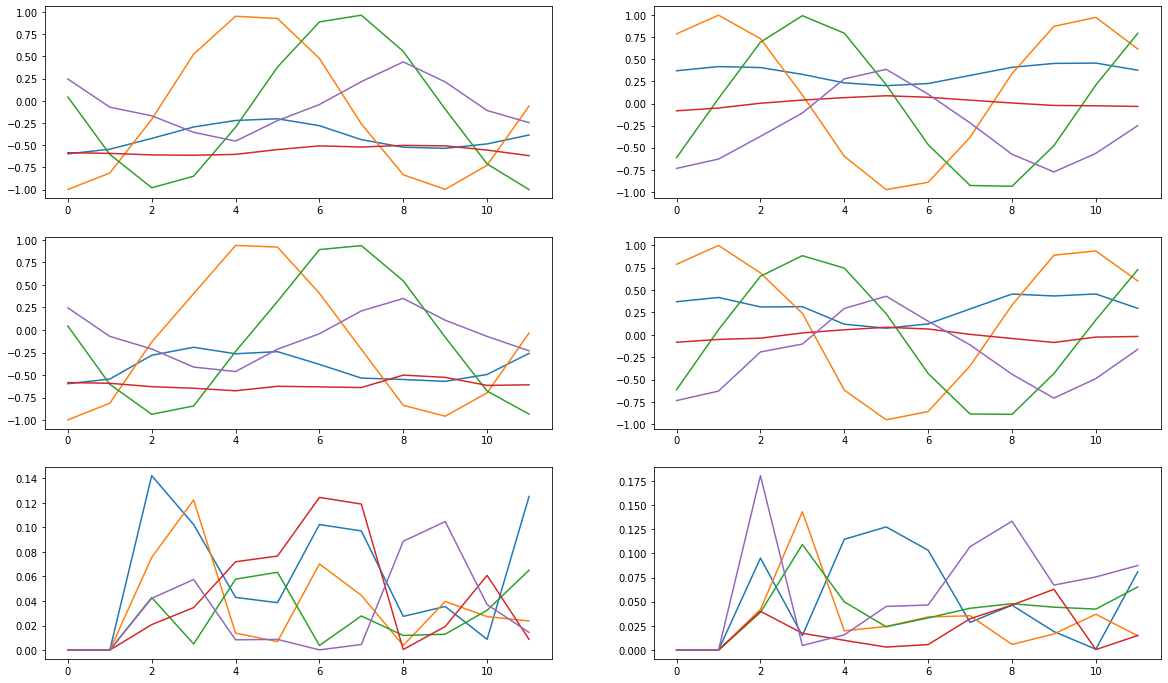

epoch: 	 0
gen loss:  0.697503 d loss:  -0.004374918 w_loss:  0.08477635
epoch: 	 1
gen loss:  0.6917752 d loss:  0.060821515 w_loss:  0.018157374
epoch: 	 2
gen loss:  0.67984194 d loss:  0.089842364 w_loss:  -0.021633726
epoch: 	 3
gen loss:  0.7130684 d loss:  0.069555946 w_loss:  0.020593438
epoch: 	 4
gen loss:  0.73286355 d loss:  0.05230487 w_loss:  0.027584722
epoch: 	 5
gen loss:  0.712566 d loss:  0.037758633 w_loss:  0.055922996
epoch: 	 6
gen loss:  0.68401104 d loss:  0.08662324 w_loss:  8.31645e-05
epoch: 	 7
gen loss:  0.67579925 d loss:  -0.009257406 w_loss:  0.1119777
epoch: 	 8
gen loss:  0.67579067 d loss:  0.0671707 w_loss:  0.012429197
epoch: 	 9
gen loss:  0.6737138 d loss:  0.04334722 w_loss:  0.028366959
epoch: 	 10
gen loss:  0.68598086 d loss:  0.02794976 w_loss:  0.06795209
epoch: 	 11
gen loss:  0.7530047 d loss:  0.054658078 w_loss:  0.042305343
epoch: 	 12
gen loss:  0.7195619 d loss:  0.058229245 w_loss:  0.021772757
epoch: 	 13
gen loss:  0.73353064 d lo

Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
O

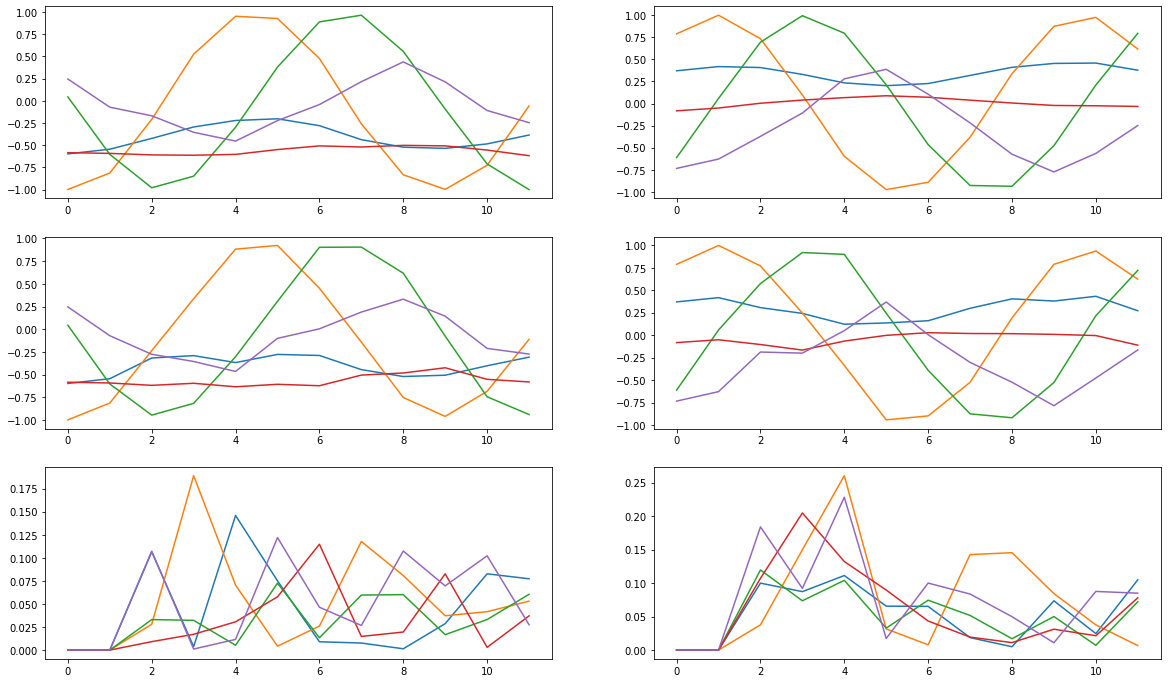

epoch: 	 0
gen loss:  0.62848693 d loss:  -0.0021551703 w_loss:  0.09416794
epoch: 	 1
gen loss:  0.6474615 d loss:  0.057341915 w_loss:  0.030566791
epoch: 	 2
gen loss:  0.67122096 d loss:  0.11774327 w_loss:  -0.027522212
epoch: 	 3
gen loss:  0.6291331 d loss:  0.058995984 w_loss:  0.026409775
epoch: 	 4
gen loss:  0.63232654 d loss:  0.055817526 w_loss:  0.03021459
epoch: 	 5
gen loss:  0.666883 d loss:  0.021472013 w_loss:  0.084052466
epoch: 	 6
gen loss:  0.69919986 d loss:  0.016913628 w_loss:  0.077204205
epoch: 	 7
gen loss:  0.6984665 d loss:  0.061884344 w_loss:  0.03211973
epoch: 	 8
gen loss:  0.7158528 d loss:  0.009687418 w_loss:  0.083951294
epoch: 	 9
gen loss:  0.6505562 d loss:  0.053723246 w_loss:  0.041863356
epoch: 	 10
gen loss:  0.6827951 d loss:  0.0364213 w_loss:  0.05429414
epoch: 	 11
gen loss:  0.6724463 d loss:  0.13419221 w_loss:  -0.051196277
epoch: 	 12
gen loss:  0.628845 d loss:  0.07081165 w_loss:  0.01557521
epoch: 	 13
gen loss:  0.65158945 d los

Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

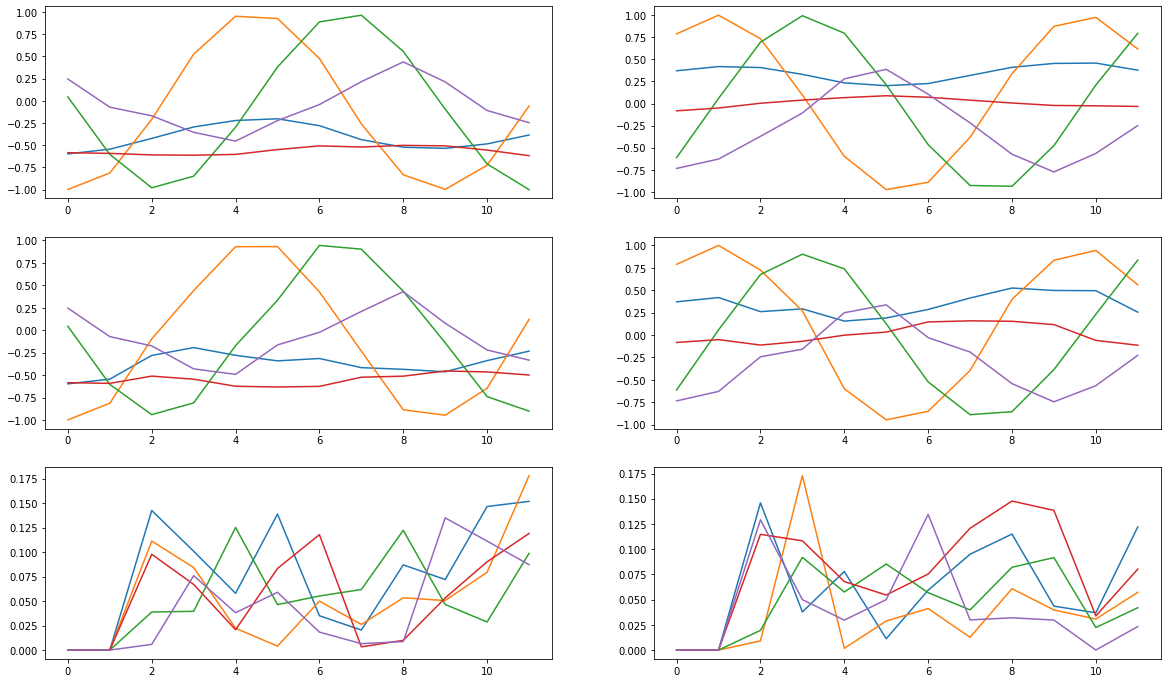

epoch: 	 0
gen loss:  0.7523168 d loss:  0.07751128 w_loss:  0.0023943402
epoch: 	 1
gen loss:  0.7419239 d loss:  0.09989972 w_loss:  -0.008543841
epoch: 	 2
gen loss:  0.73734736 d loss:  0.08373073 w_loss:  -0.00037018023
epoch: 	 3
gen loss:  0.7216462 d loss:  0.047086142 w_loss:  0.030184885
epoch: 	 4
gen loss:  0.7089434 d loss:  0.09635012 w_loss:  -0.012131535
epoch: 	 5
gen loss:  0.66848695 d loss:  0.11859508 w_loss:  -0.034100357
epoch: 	 6
gen loss:  0.71535546 d loss:  0.024185052 w_loss:  0.06579077
epoch: 	 7
gen loss:  0.7568363 d loss:  0.1060349 w_loss:  -0.015543222
epoch: 	 8
gen loss:  0.73386294 d loss:  0.016935233 w_loss:  0.070241466
epoch: 	 9
gen loss:  0.65424377 d loss:  0.08882548 w_loss:  -0.00073842925
epoch: 	 10
gen loss:  0.70240605 d loss:  0.041826066 w_loss:  0.03582467
epoch: 	 11
gen loss:  0.6997492 d loss:  0.07665382 w_loss:  0.022312826
epoch: 	 12
gen loss:  0.7670329 d loss:  0.11227302 w_loss:  -0.008065313
epoch: 	 13
gen loss:  0.7081

Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 2
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
O

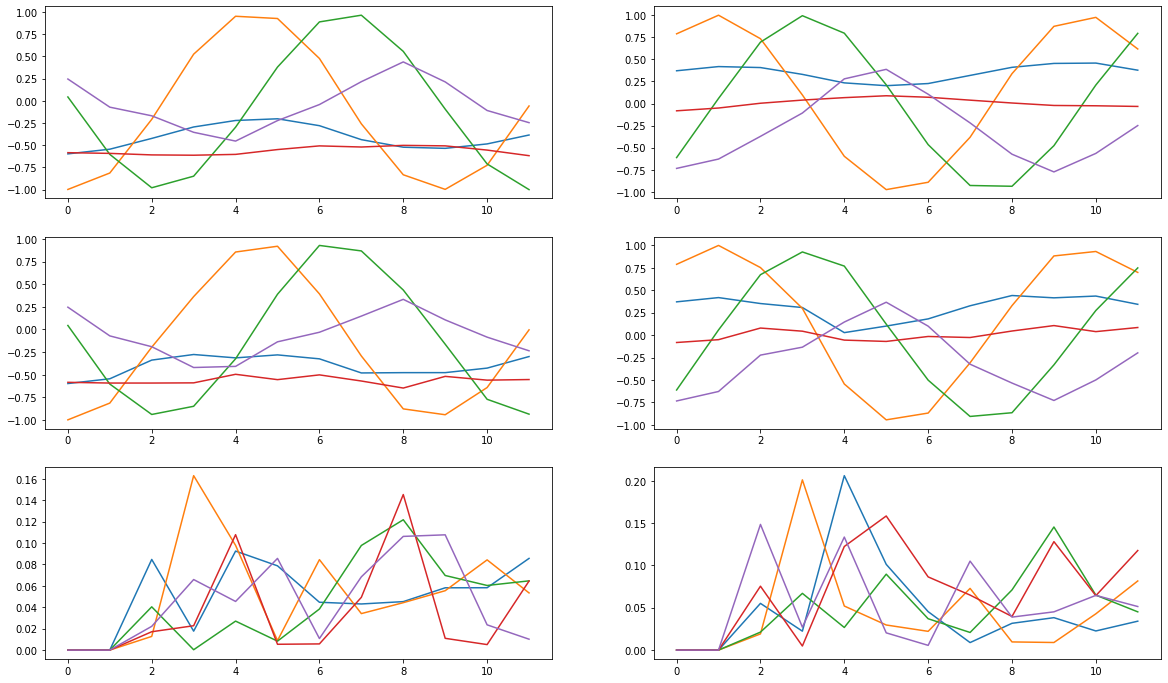

epoch: 	 0
gen loss:  0.5991762 d loss:  0.05897526 w_loss:  0.04129112
epoch: 	 1
gen loss:  0.6641787 d loss:  0.08243164 w_loss:  0.009839262
epoch: 	 2
gen loss:  0.6446372 d loss:  0.062804624 w_loss:  0.038015023
epoch: 	 3
gen loss:  0.59785545 d loss:  0.0755738 w_loss:  0.0053407303
epoch: 	 4
gen loss:  0.6597009 d loss:  0.053646423 w_loss:  0.032498144
epoch: 	 5
gen loss:  0.64982617 d loss:  0.08098371 w_loss:  0.012404081
epoch: 	 6
gen loss:  0.6418268 d loss:  0.031321563 w_loss:  0.06402326
epoch: 	 7
gen loss:  0.6171965 d loss:  0.0037340298 w_loss:  0.0888615
epoch: 	 8
gen loss:  0.6586346 d loss:  0.048705198 w_loss:  0.027852755
epoch: 	 9
gen loss:  0.618672 d loss:  0.10968093 w_loss:  -0.0011837557
epoch: 	 10
gen loss:  0.66436416 d loss:  0.084942095 w_loss:  0.022720043
epoch: 	 11
gen loss:  0.6605816 d loss:  0.06681769 w_loss:  0.019663457
epoch: 	 12
gen loss:  0.6624142 d loss:  0.029905543 w_loss:  0.05045874
epoch: 	 13
gen loss:  0.6791719 d loss: 

In [21]:
for i in range(20):
    kwargs_opt = {
        "start_from" : 800,
        "nPOD" : nPOD,
        "nLatent" : 100,
        "npredictions" : 10,
        "optimizer_epochs" : 50,
        "dt" : step_size,
        "gan" : gan,
        "cycles" : 10,
        "debug" : debug,
        "disturb" : True
    }

    optimizer = Optimize(**kwargs_opt)
    fld = optimizer.predictDD(training_data,
                               tf.convert_to_tensor(np.array(boundrary_conditions, dtype=np.float32)),
                               dim_steps=added_dims)

    show_dims = 5
    fig = plt.figure(figsize=(20, 12))

    ax1 = fig.add_subplot(321)
    ax1.plot(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:show_dims])
    ax1 = fig.add_subplot(323)
    ax1.plot(fld[0, :, :show_dims])
    ax1 = fig.add_subplot(325)
    ax1.plot(np.abs(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld[0,:, :show_dims]))


    ax1 = fig.add_subplot(322)
    ax1.plot(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims])
    ax1 = fig.add_subplot(324)
    ax1.plot(fld[1, :, :show_dims])
    ax1 = fig.add_subplot(326)
    ax1.plot(np.abs(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld[1, :, :show_dims]))

    plt.show()
    
    gan.resume_training(joined_train_data, 0)

Time step: 	 0
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 11
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 21
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Opti

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 31
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 41
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Opti

Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 51
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Opti

Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 61
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Opti

Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 71
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Opti

Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 81
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Opti

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 91
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

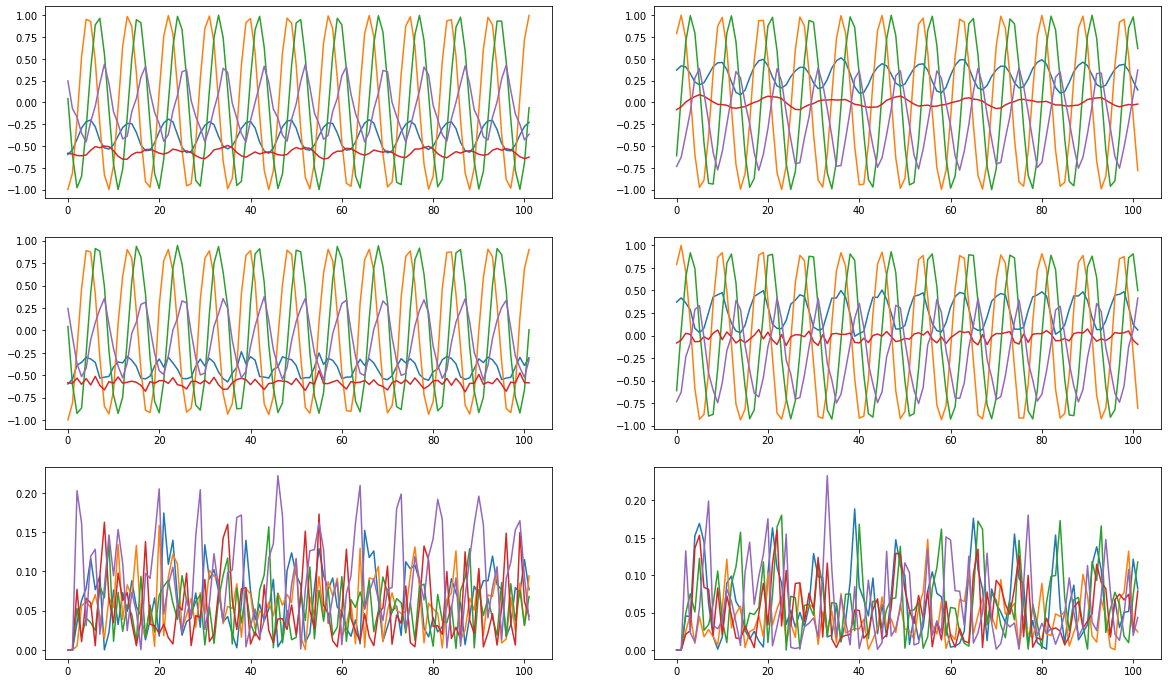

In [29]:
kwargs_opt = {
    "start_from" : 800,
    "nPOD" : nPOD,
    "nLatent" : 100,
    "npredictions" : 100,
    "optimizer_epochs" : 50,
    "dt" : step_size,
    "gan" : gan,
    "cycles" : 10,
    "debug" : debug,
    "disturb" : True
}

optimizer = Optimize(**kwargs_opt)
fld = optimizer.predictDD(training_data,
                           tf.convert_to_tensor(np.array(boundrary_conditions, dtype=np.float32)),
                           dim_steps=added_dims)

show_dims = 5
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:show_dims])
ax1 = fig.add_subplot(323)
ax1.plot(fld[0, :, :show_dims])
ax1 = fig.add_subplot(325)
ax1.plot(np.abs(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld[0,:, :show_dims]))


ax1 = fig.add_subplot(322)
ax1.plot(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims])
ax1 = fig.add_subplot(324)
ax1.plot(fld[1, :, :show_dims])
ax1 = fig.add_subplot(326)
ax1.plot(np.abs(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld[1, :, :show_dims]))

plt.show()

Time step: 	 0
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 1
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Do

Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 11
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle:

Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 21
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Opti

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 31
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 41
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Opti

Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 51
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Opti

Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 61
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Opti

Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 71
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Opti

Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 81
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Opti

Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 9
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Time step: 	 91
Cycle: 	 0
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 1
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 2
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 3
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 4
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 5
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 6
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 7
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch: 	 0
Cycle: 	 8
Domain: 	 0
Optimizer epoch: 	 0
Domain: 	 1
Optimizer epoch

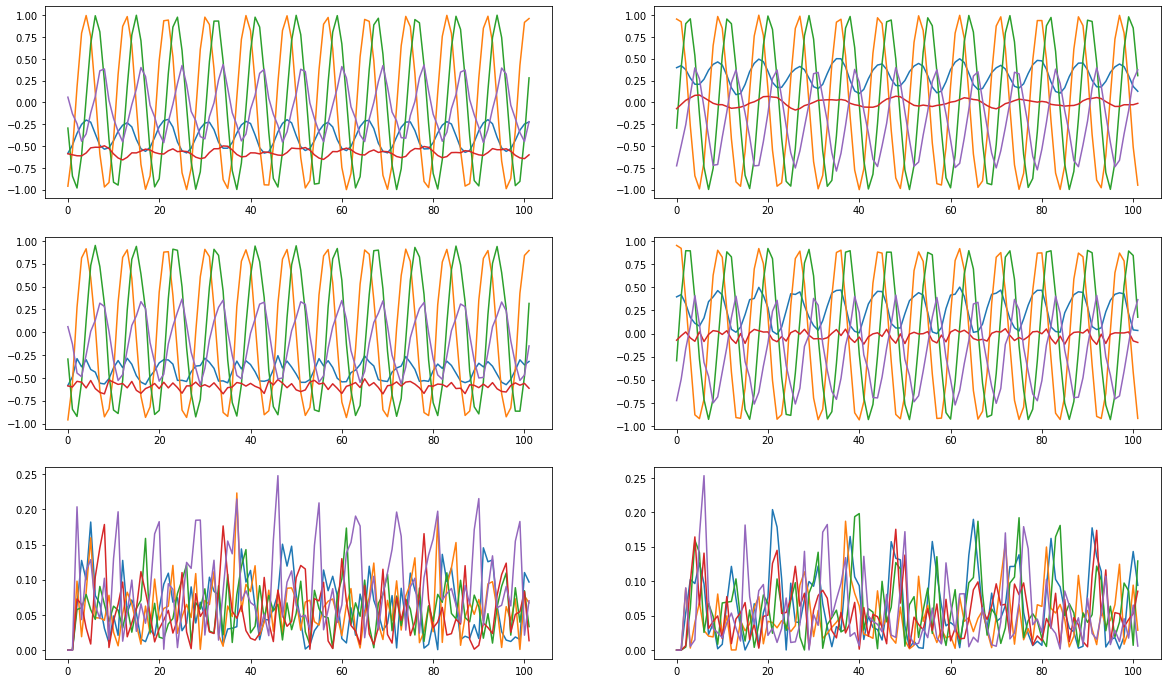

In [30]:
kwargs_opt = {
    "start_from" : 802,
    "nPOD" : nPOD,
    "nLatent" : 100,
    "npredictions" : 100,
    "optimizer_epochs" : 50,
    "dt" : step_size,
    "gan" : gan,
    "cycles" : 10,
    "debug" : debug,
    "disturb" : True
}

optimizer = Optimize(**kwargs_opt)
fld1 = optimizer.predictDD(training_data,
                           tf.convert_to_tensor(np.array(boundrary_conditions, dtype=np.float32)),
                           dim_steps=added_dims)

show_dims = 5
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:show_dims])
ax1 = fig.add_subplot(323)
ax1.plot(fld1[0, :, :show_dims])
ax1 = fig.add_subplot(325)
ax1.plot(np.abs(scaled_training[1,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld1[0,:, :show_dims]))


ax1 = fig.add_subplot(322)
ax1.plot(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims])
ax1 = fig.add_subplot(324)
ax1.plot(fld1[1, :, :show_dims])
ax1 = fig.add_subplot(326)
ax1.plot(np.abs(scaled_training[2,optimizer.start_from:optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size, :show_dims] - fld1[1, :, :show_dims]))

plt.show()

In [35]:
a=np.reshape(np.ravel([fld[0],fld1[0]], "F"),[10,-1]).T
b=np.reshape(np.ravel([fld[1],fld1[1]], "F"),[10,-1]).T

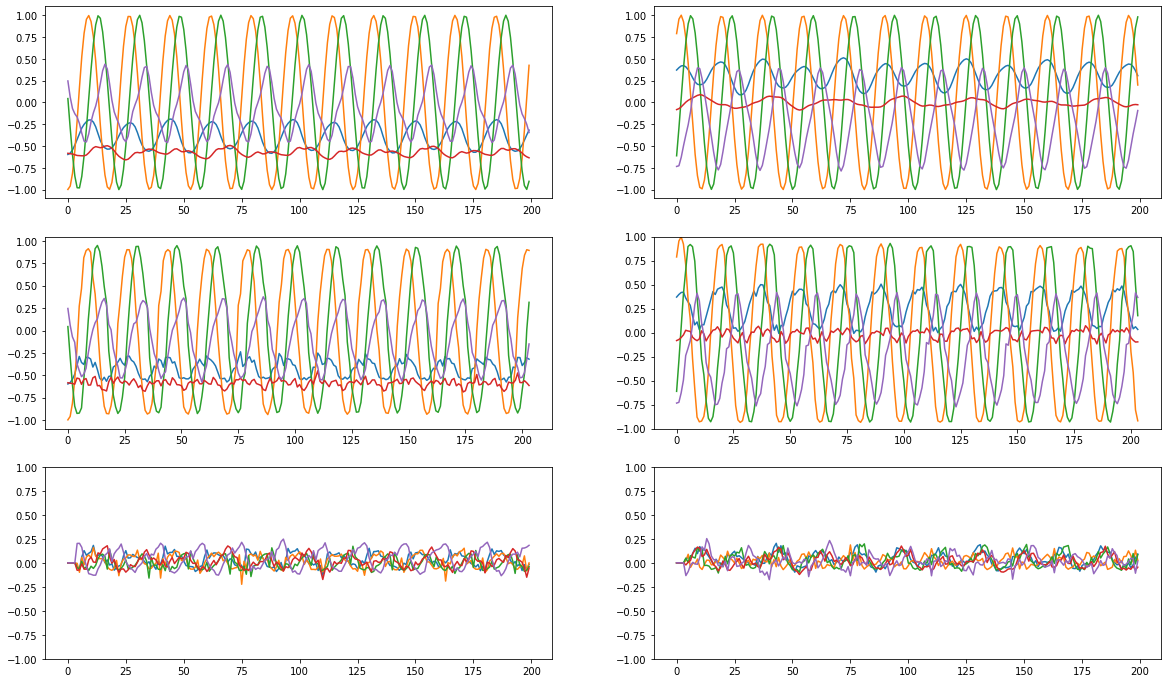

In [39]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scaled_training[1, 800:800 + 100*4:2, :show_dims])
ax1 = fig.add_subplot(323)
ax1.plot(a[:,:show_dims])
ax1 = fig.add_subplot(325)
ax1.plot(scaled_training[1, 800:800 + 100*4:2, :show_dims]- a[:200,:show_dims])
ax1.set_ylim([-1,1])

ax1 = fig.add_subplot(322)
ax1.plot(scaled_training[2, 800:800 + 100*4:2, :show_dims])
ax1 = fig.add_subplot(324)
ax1.plot(b[:,:show_dims])
plt.ylim([-1,1])
ax1 = fig.add_subplot(326)
ax1.plot(scaled_training[2, 800:800 + 100*4:2, :show_dims]- b[:200,:show_dims])
ax1.set_ylim([-1,1])

plt.show()

In [40]:
a1 = scales[1].inverse_transform(a)
b1 = scales[2].inverse_transform(b)

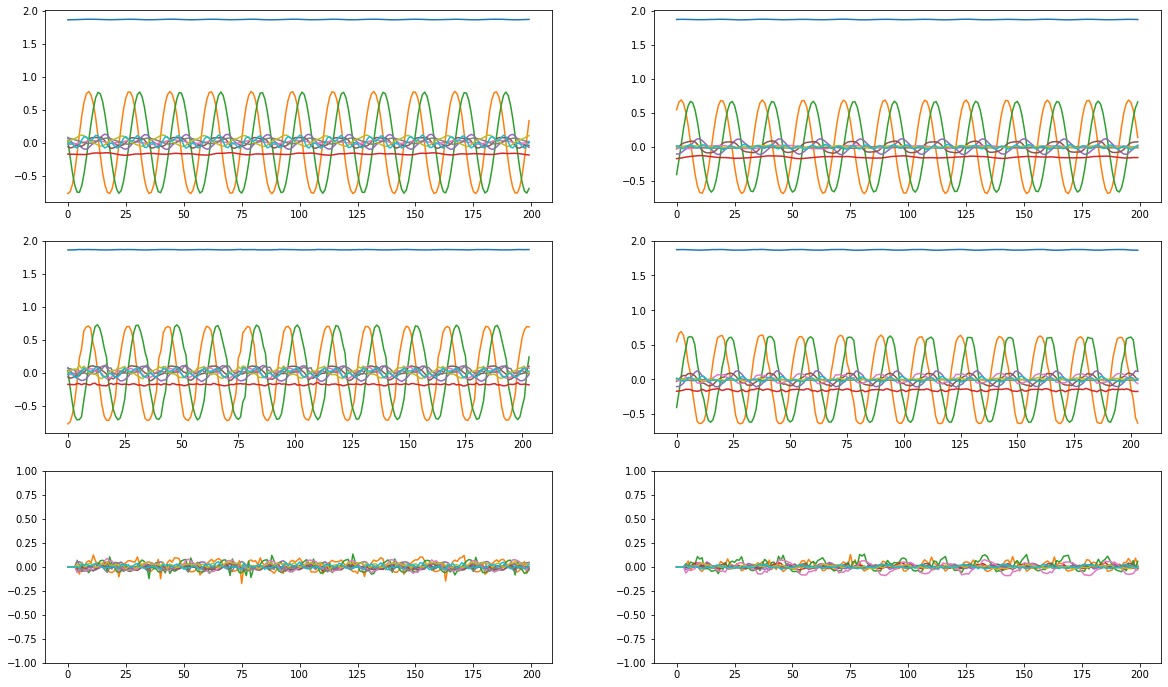

In [42]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(321)
ax1.plot(scales[1].inverse_transform(scaled_training[1, 800:800 + 100*4:2]))
ax1 = fig.add_subplot(323)
ax1.plot(a1[:])
ax1 = fig.add_subplot(325)
ax1.plot(scales[1].inverse_transform(scaled_training[1, 800:800 + 100*4:2])- a1[:200])
ax1.set_ylim([-1,1])

ax1 = fig.add_subplot(322)
ax1.plot(scales[2].inverse_transform(scaled_training[2, 800:800 + 100*4:2]))
ax1 = fig.add_subplot(324)
ax1.plot(b1[:])
ax1 = fig.add_subplot(326)
ax1.plot(scales[2].inverse_transform(scaled_training[2, 800:800 + 100*4:2])- b1[:200])
ax1.set_ylim([-1,1])

plt.show()

In [ ]:
pause

In [ ]:
basis = np.load('../data/processed/pod_basis_field_Velocity.npy')

In [ ]:
final_data = []
rect = 18
final_data.append(scales[0].inverse_transform((scaled_training[0,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)
for i in range(2):
    final_data.append(scales[1+i].inverse_transform(flds[i]).T)
    
final_data.append(scales[3].inverse_transform((scaled_training[3,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)

In [ ]:
org_data = []
for i in range(4):
    org_data.append(scales[i].inverse_transform((scaled_training[i,optimizer.start_from+rect:rect+optimizer.start_from + (added_dims[-1]-1+optimizer.npredictions) * step_size: step_size,:nPOD])).T)

In [ ]:
cutoff = 40
final_data = np.array(final_data)[:,:,:cutoff]
org_data = np.array(org_data)[:,:,:cutoff]

In [ ]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(final_data[0].T)
ax1 = fig.add_subplot(412)
ax1.plot(final_data[1].T)
ax1 = fig.add_subplot(413)
ax1.plot(final_data[2].T)
ax1 = fig.add_subplot(414)
ax1.plot(final_data[3].T)

plt.show()

In [ ]:
print_data = []

for i in range(4):
    print_data.append((basis[:,:gan.ndims] @ final_data[i]))

print_data = np.array(print_data).reshape([4, 2, 55, 42, 40])
np.save('../data/reconstructed/Velocity_field_predict_DD.npy', print_data )

In [ ]:
org_data_re = []

for i in range(4):
    org_data_re.append(basis[:,:gan.ndims] @ org_data[i])

org_data_re = np.array(org_data_re).reshape([4, 2, 55, 42, 40])
np.save('../data/reconstructed/velocity_field_org_DD.npy', org_data_re )